# Spam Classification

The objective of it is to generate a model capable to classify a email as spam or not spam (Ham).

The dataset used was from http://www2.aueb.gr/users/ion/data/enron-spam/

#### Imports

In [1]:
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text as txt
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import email
from email.message import EmailMessage
from email.parser import BytesParser, Parser
from email.policy import default
import ast
import re
import datetime
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /home/phrc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/phrc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Functions

In [125]:
def createDf(path):
    """
    Read all email files and convert to a dataframe

    Parameters
    ----------
    path: str
        Path to a root directory to be read

    Returns
    ----------
    dataframe
        a dataframe with x columns based in all emails properties
    """
    os.chdir(path)
    data = []
    for root, dirs, files in os.walk(path):
         for file in files:
            with open(os.path.join(root, file), "rb") as openFile:
                dictTemp = {}
                try:
                    message = email.message_from_binary_file(openFile, policy=default)
                    #Parser(policy=default).parsestr(openFile.read())
                    dictTemp['file'] = openFile.name
                    for key in message.keys():
                        dictTemp[key.lower()] = message[key]
                    dictTemp['messageType'] = message.get_content_type()
                    body = message.get_body()
                    if body['content-type'].maintype == 'text':
                        if body['content-type'].subtype == 'plain':
                            dictTemp['messageStr'] = str(body.get_content())
                        elif body['content-type'].subtype == 'html':
                            dictTemp['messageStr'] = str(body)
                    elif body['content-type'].content_type in 'multipart':
                        dictTemp['messageStr'] = str(body.get_body(preferencelist=('html')))
                    dictTemp['parseError'] = False                 
                except:
                    dictTemp['parseError'] = True
                data.append(dictTemp)
    df = pd.DataFrame(data)
    return df

def emailTextCleanner(text):
    """
    Remove:
        Html Tags
        Email headers
        Ponctuation
        break lines and tabs
    
    And convert the string to lower case 

    Parameters
    ----------
    text: str

    Returns
    ----------
    str
    """
    try:
        text = str(text).lower()
        text = text.replace("\\", " ")
        text = text.replace("\x01", " ")
        clean = re.compile('charset.*\n')
        text = re.sub(clean, '', text)
        clean = re.compile('content-.*\n')
        text = re.sub(clean, '', text)
        clean = re.compile('received: from.*\n')
        text = re.sub(clean, '', text)
        text = text.replace('\n', ' ')
        text = text.replace('\t', ' ')
        clean = re.compile('<.*?>')
        text = re.sub(clean, '', str(text))
        clean = re.compile('['+string.punctuation+']')
        text = re.sub(clean, ' ', text)
        clean = re.compile("[0-9]")
        text = re.sub(clean, " ", text)
        toRemove = frozenset(['xpriority','nbsp', 'enron','xmsmailpriority','xmimeole','mimeole','cc','enrons', 'fw', 're'])
        pattern = re.compile(r'\b(' + r'|'.join(toRemove) + r')\b\s*')
        text = pattern.sub(' ', text)
 
        return text
    except:
        print(type(text))
        return ""
    #text = TextBlob(text)
    #text = str(text.correct())
    
def lemmatizeList(words):
    """
    Lemmatize a list of string

    Parameters
    ----------
    words: list of str

    Returns
    ----------
    list of str
    """
    lem = WordNetLemmatizer()
    for i in range(len(words)):
        words[i] = lem.lemmatize(words[i], 'v')
        words[i] = lem.lemmatize(words[i], 'n')
    return words

def revomeWordsWithOneCharacter(words):
    return list(filter(lambda x : len(x) > 1, words))

def removeDigits(words):
    return list(filter(lambda x : x.isdigit() == False, words))

def createPlotLenghtDist(col, df, title=""):
    fig = plt.figure(figsize = (18,6))
    grid = plt.GridSpec(1,4, wspace =0.8)
    histPlt = fig.add_subplot(grid[0,0:2])
    boxPlt1 = fig.add_subplot(grid[0,2])
    boxPlt2 = fig.add_subplot(grid[0,3])

    histPlt.hist(
        [
            df[df['isSpam'] == True][col], 
            df[df['isSpam'] == False][col]
        ], 
        np.linspace(0, df[col].quantile(0.75), 30), 
        density = True, 
        label=['Spam', 'Ham']
    ) 
    histPlt.legend(loc='upper right')

    boxPlt1.boxplot(
        (
             df[df['isSpam'] == True][col], 
             df[df['isSpam'] == False][col] 
        ), 
        labels = ('Spam', 'Ham')
    )

    boxPlt2.boxplot(
        (
            df[(df['isSpam'] == True) & (df[col] < df[col].quantile(0.75))][col], 
            df[(df['isSpam'] == False) & (df[col] < df[col].quantile(0.75))][col] 
        ), 
        labels = ('Spam', 'Ham')
    )
    fig.suptitle(title, fontsize=16)
    plt.show()

def plot20MostWord(counter, title="", ls=[]):
    df = pd.DataFrame(list(dict(counter).items()))
    df.columns = ['word', 'occur'] 
    totalOcurr = df['occur'].sum()
    df['freq'] = df['occur'] / totalOcurr  
    df = df.sort_values(by='freq', ascending=False)
    df = df.reset_index(drop=True)
    df['freqAcum'] = df['freq'].cumsum()


    fig = plt.figure(figsize = (18,12))
    grid = plt.GridSpec(4,2, wspace =0.2, hspace = 0.5)
    pltLine = fig.add_subplot(grid[0:2,0])
    pltBar = fig.add_subplot(grid[2:4,0:2])
    pltTable = fig.add_subplot(grid[0:2,1])

    pltLine.plot(df['freqAcum'], range(len(df)))
    pltLine.set_ylabel('Number of Words')
    pltLine.set_xlabel('Acumulative Frequence')
    pltLine.set_title('Line Graph of acumulative frequence')
    pltLine.grid(True)

    ls = ls + [0,20,50,100,500,1000,5000,10000,15000]
    ls.sort()
    dfTWord = df.loc[ls][['freqAcum']]

    pltTable.table(cellText=dfTWord.values, rowLabels= dfTWord.index, colLabels = dfTWord.columns, loc='best')
    pltTable.axis('off')
    pltTable.set_title('Table of acumulative frequence')



    pltBar.bar(df.head(20)['word'], df.head(20)['freq'])
    pltBar.set_title('20 Most Used word')

    yPos = np.arange(20)
    pltBar.set_xticklabels(df.head(20)["word"], rotation=60)
    pltBar.set_xticks(yPos)
    fig.suptitle(title, fontsize=16)

    plt.show()
    
def totalUniqueWordsPlot(l1,l2,l3, title=""):
    fig = plt.figure(figsize = (18,6))
    grid = plt.GridSpec(1,2, wspace =0.2)
    pltBar = fig.add_subplot(grid[0,0])
    pltText = fig.add_subplot(grid[0,1])

    pltBar.bar(
        ['Total unique words', 'Spam unique words', 'Ham unique words'], 
        [l1,l2,l3], 
        align='center'
    )

    textWords = ['Total unique words:              {}'.format(l1), 
                 'Total spam unique words:    {}'.format(l2), 
                 'Total ham unique words:      {}'.format(l3)]



    pltText.text(x=0, y=0.5, s = '\n'.join(textWords), fontsize = 18) 
    pltText.axis('off')
    fig.suptitle(title, fontsize=16)
    plt.show()

def getEmailRoot(email):
    try:
        email1 = email.replace(".", " ")
        emailVet = email1.split()
        matching = [s for s in emailVet if "@" in s] 
        return matching[0].replace("<", "").replace(">", "")
    except:
        return "None" 

def getEmailPartRoot(root, i):
    try:
        return root.split("@")[i]
    except:
        return "None"

def train_model(classifier, feature_vector_train, label, feature_vector_valid, ytest):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_valid)
    return metrics.accuracy_score(predictions, ytest)

## Dataset generation

In [3]:
root = '/home/phrc/Python Project/Spam Email Classifier/'
#root = '/Users/phrc/Documents/Projects/pythonProject/SpamEmailClassifier/'

spamPath = root+'emails/spam/'
hamPath = root+'emails/ham/'


dfSpam = createDf(spamPath)
dfHam = createDf(hamPath)

dfSpam['isSpam'] = True
dfHam['isSpam'] = False

In [4]:
dfSpamCopy = dfSpam.copy()
dfHamCopy = dfHam.copy()

In [5]:
dfSpam = dfSpamCopy
dfHam = dfHamCopy

# Dataset Visualisation and Preparation 

## Dataset Size

Total emails 52076


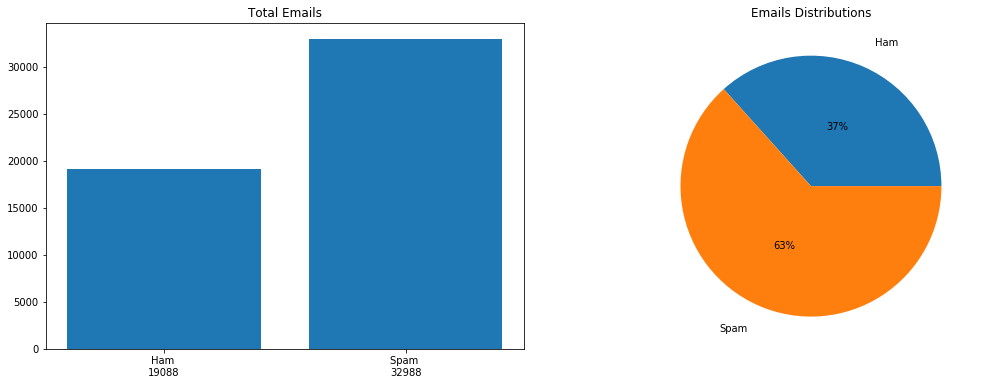

In [6]:
print("Total emails {}".format(len(dfHam) + len(dfSpam)))

initTotalSpam = len(dfSpam)
initTotalHam = len(dfHam)

fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,2, wspace =0.1)
barPlt = fig.add_subplot(grid[0,0])
piePlt = fig.add_subplot(grid[0,1])


barPlt.bar(np.arange(2), (len(dfHam), len(dfSpam)), align='center')
barPlt.set_xticklabels(('Ham \n{}'.format(len(dfHam)), 'Spam \n{}'.format(len(dfSpam))))
barPlt.set_xticks(np.arange(2))
barPlt.set_title("Total Emails")


piePlt.pie((len(dfHam), len(dfSpam)), labels=['Ham', 'Spam'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
piePlt.set_title("Emails Distributions")

plt.show()

## Parser Emails Error Analyse 

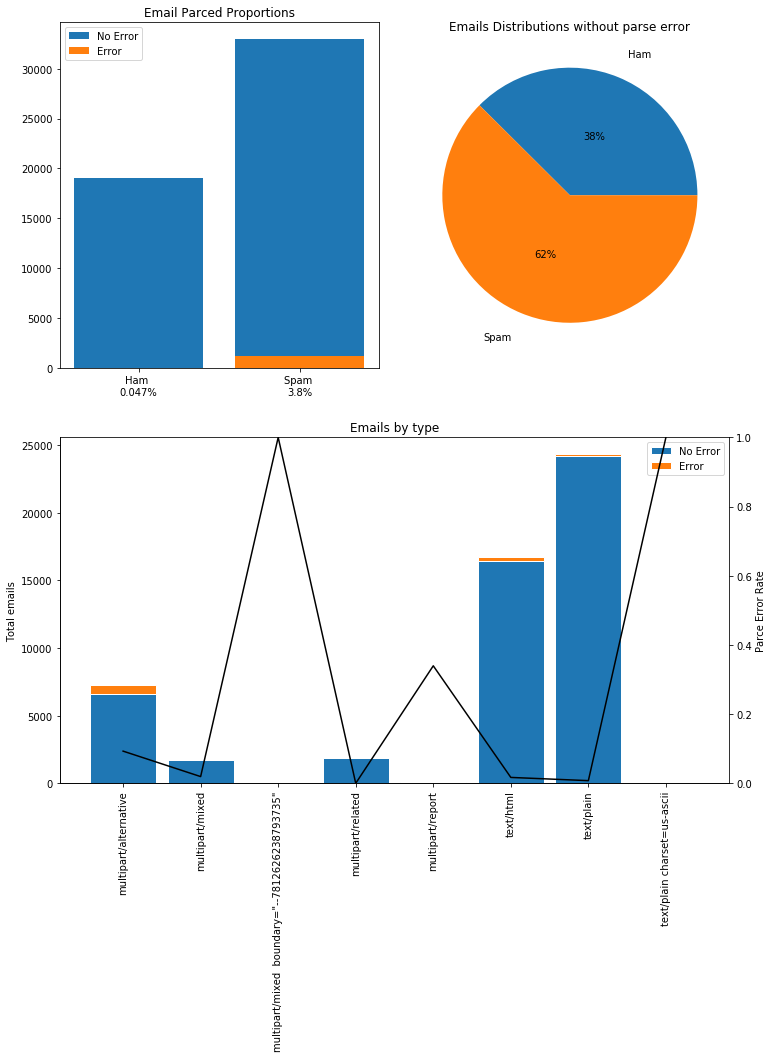

In [7]:
fig = plt.figure(figsize = (12,14))
grid = plt.GridSpec(2,2, wspace =0.1)
barPlt = fig.add_subplot(grid[0,0])
piePlt = fig.add_subplot(grid[0,1])
stackBar = fig.add_subplot(grid[1,0:2])
line = stackBar.twinx()


hamFreq = (len(dfHam[dfHam['parseError'] == True]) * 100 / len(dfHam))
spamFreq = (len(dfSpam[dfSpam['parseError'] == True]) * 100 / len(dfSpam))


p1 = barPlt.bar(np.arange(2), 
           (len(dfHam),
            len(dfSpam)
           ), align='center')

p2 = barPlt.bar(np.arange(2), 
           (len(dfHam[dfHam['parseError'] == True]),
            len(dfSpam[dfSpam['parseError'] == True])
           ), align='center')

barPlt.set_xticks(np.arange(2))
barPlt.set_xticklabels(('Ham \n{0:.2}%'.format(hamFreq), 'Spam \n{0:.2}%'.format(spamFreq)))
barPlt.set_title("Email Parced Proportions")
barPlt.legend((p1[0], p2[0]), ('No Error', 'Error'))


piePlt.pie(
    (
        len(dfHam[dfHam['parseError'] == False]), 
        len(dfSpam[dfSpam['parseError'] == False])), 
    labels=['Ham', 'Spam'], 
    autopct='%1.0f%%', 
    pctdistance=0.5, 
    labeldistance=1.2)
piePlt.set_title("Emails Distributions without parse error")

dfParse = pd.concat(
    [dfSpam[['messageType', 'isSpam', 'parseError']], 
     dfHam[['messageType', 'isSpam', 'parseError']]], 
    sort=True)

dfGroup2 = dfParse.groupby(['messageType', 'parseError']).size()
dfG2 = dfGroup2.unstack().fillna(0)
dfG2['ParseErrorRate'] = dfG2[True] / (dfG2[True] + dfG2[False])  

p22 =stackBar.bar(range(len(dfG2)), dfG2[False], edgecolor='white', width=0.85)
p23 =stackBar.bar(range(len(dfG2)), dfG2[True], bottom = dfG2[False], edgecolor='white', width=0.85)


stackBar.set_xticks(range(len(dfG2)))
stackBar.set_xticklabels(dfG2.index.values, rotation='vertical')
stackBar.spines['top'].set_visible(False)
stackBar.spines['right'].set_visible(False)
stackBar.get_xaxis().tick_bottom()
stackBar.get_yaxis().tick_left()
stackBar.set_title("Emails by type")
stackBar.legend((p22[0], p23[0]), ('No Error','Error'))
stackBar.set_ylabel('Total emails', color='black')

line.plot(range(len(dfG2)), dfG2['ParseErrorRate'], color = 'black')
line.get_yaxis().tick_right()
line.set_ylim(0, 1)
line.set_ylabel('Parce Error Rate', color='black')




plt.show();

In [8]:
dfG2

parseError,False,True,ParseErrorRate
messageType,,,
multipart/alternative,6564.0,673.0,0.092994
multipart/mixed,1717.0,34.0,0.019417
"multipart/mixed boundary=""--7812626238793735""",0.0,1.0,1.000000
multipart/related,1892.0,0.0,0.000000
multipart/report,70.0,36.0,0.339623
text/html,16431.0,284.0,0.016991
text/plain,24154.0,187.0,0.007683
text/plain charset=us-ascii,0.0,1.0,1.000000


## Check for Empty e-mail messages without parce error

In [9]:
dfMsg = pd.concat([dfSpam[['messageStr', 'messageType', 'isSpam', 'parseError']], dfHam[['messageType', 'messageStr', 'isSpam', 'parseError']]], sort=True)
dfMsg = dfMsg[dfMsg['parseError'] == False]
dfMsg['msgIsNull'] = dfMsg['messageStr'].isnull()


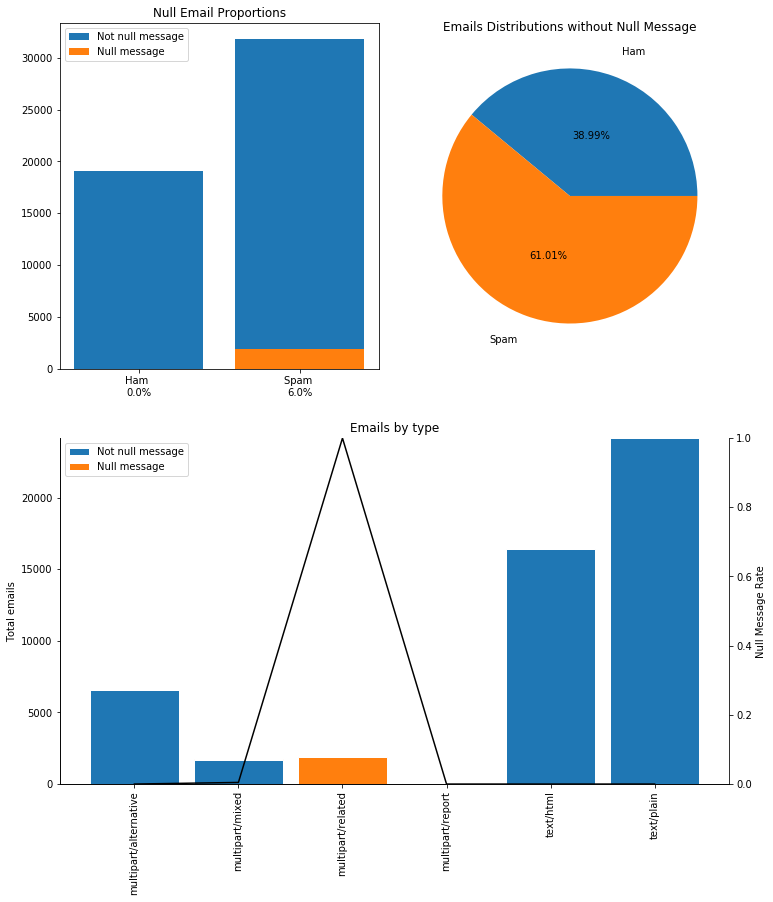

In [10]:
fig = plt.figure(figsize = (12,14))
grid = plt.GridSpec(2,2, wspace =0.1)
barPlt = fig.add_subplot(grid[0,0])
piePlt = fig.add_subplot(grid[0,1])
stackBar = fig.add_subplot(grid[1,0:2])
line = stackBar.twinx()

hamFreq = (len(dfMsg[(dfMsg['isSpam'] == False) & (dfMsg['msgIsNull'] == True)]) * 100 / len(dfMsg[dfMsg['isSpam'] == False]))
spamFreq = (len(dfMsg[(dfMsg['isSpam'] == True) & (dfMsg['msgIsNull'] == True)]) * 100 / len(dfMsg[dfMsg['isSpam'] == True]))


p1 = barPlt.bar(np.arange(2), 
           (len(dfMsg[dfMsg['isSpam'] == False]),
            len(dfMsg[dfMsg['isSpam'] == True])
           ), align='center')

p2 = barPlt.bar(np.arange(2), 
           (len(dfMsg[(dfMsg['isSpam'] == False) & (dfMsg['msgIsNull'] == True)]),
            len(dfMsg[(dfMsg['isSpam'] == True) & (dfMsg['msgIsNull'] == True)])
           ), align='center')

barPlt.set_xticks(np.arange(2))
barPlt.set_xticklabels(('Ham \n{0:.2}%'.format(hamFreq), 'Spam \n{0:.2}%'.format(spamFreq)))
barPlt.set_title("Null Email Proportions")
barPlt.legend((p1[0], p2[0]), ('Not null message','Null message'))


piePlt.pie(
    (
        len(dfMsg[(dfMsg['isSpam'] == False) & (dfMsg['msgIsNull'] == False)]), 
        len(dfMsg[(dfMsg['isSpam'] == True) & (dfMsg['msgIsNull'] == False)])), 
    labels=['Ham', 'Spam'], 
    autopct='%1.2f%%', 
    pctdistance=0.5, 
    labeldistance=1.2)
piePlt.set_title("Emails Distributions without Null Message")

dfGroup2 = dfMsg.groupby(['messageType', 'msgIsNull']).size()
dfG2 = dfGroup2.unstack().fillna(0)
dfG2['NullMsgRate'] = dfG2[True] / (dfG2[True] + dfG2[False])  

p22 =stackBar.bar(range(len(dfG2)), dfG2[False], edgecolor='white', width=0.85)
p23 =stackBar.bar(range(len(dfG2)), dfG2[True], bottom = dfG2[False], edgecolor='white', width=0.85)


stackBar.set_xticks(range(len(dfG2)))
stackBar.set_xticklabels(dfG2.index.values, rotation='vertical')
stackBar.spines['top'].set_visible(False)
stackBar.spines['right'].set_visible(False)
stackBar.get_xaxis().tick_bottom()
stackBar.get_yaxis().tick_left()
stackBar.set_title("Emails by type")
stackBar.legend((p22[0], p23[0]), ('Not null message','Null message'))
stackBar.set_ylabel('Total emails', color='black')

line.plot(range(len(dfG2)), dfG2['NullMsgRate'], color = 'black')
line.get_yaxis().tick_right()
line.set_ylim(0, 1)
line.spines['top'].set_visible(False)
line.set_ylabel('Null Message Rate', color='black')




plt.show();

In [11]:
dfG2

msgIsNull,False,True,NullMsgRate
messageType,,,
multipart/alternative,6564.0,0.0,0.000000
multipart/mixed,1709.0,8.0,0.004659
multipart/related,0.0,1892.0,1.000000
multipart/report,70.0,0.0,0.000000
text/html,16431.0,0.0,0.000000
text/plain,24154.0,0.0,0.000000


## Remove Empty e-mail messages 

In [12]:
dfNoError = dfMsg[(dfMsg['parseError'] == False) & (dfMsg['msgIsNull'] == False)]

print('Total size of dataset: {}'.format(len(dfNoError)))


Total size of dataset: 48928


## Emails losted analyse

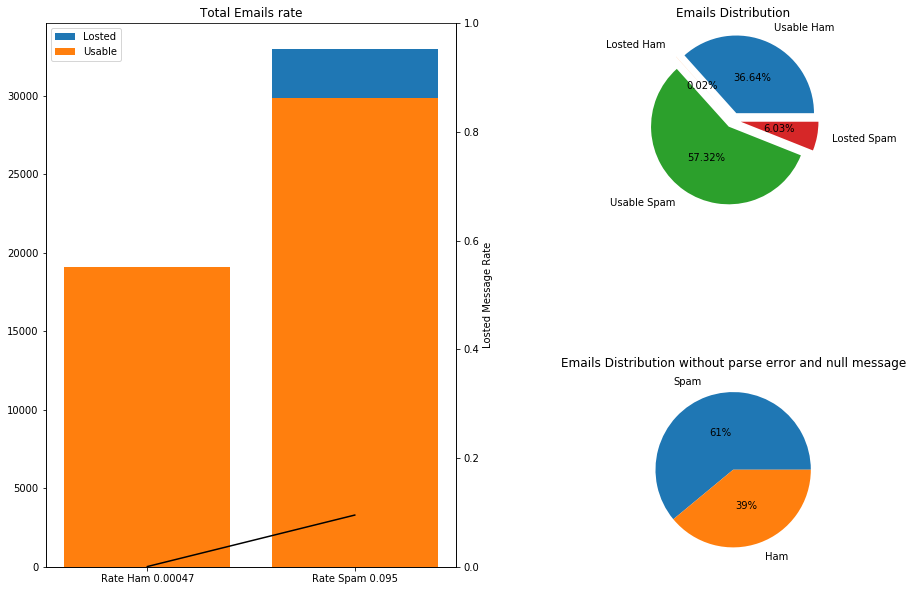

In [13]:
fig = plt.figure(figsize = (16,10))
grid = plt.GridSpec(2,6, wspace =0.8, hspace =0.8)
stackBar = fig.add_subplot(grid[0:2,0:3])
piePlt = fig.add_subplot(grid[0,3:6])
piePlt2 = fig.add_subplot(grid[1,3:6])
line = stackBar.twinx()


p1 = stackBar.bar(np.arange(2), 
           (initTotalHam,
            initTotalSpam
           ), align='center')

p2 = stackBar.bar(np.arange(2), 
           (len(dfNoError[dfNoError['isSpam'] == False]),
            len(dfNoError[dfNoError['isSpam'] == True])
           ), align='center')

stackBar.set_xticklabels(
    ('Rate Ham {0:.2}'.format(((initTotalHam - len(dfNoError[dfNoError['isSpam'] == False])) / initTotalHam)), 
     'Rate Spam {0:.2}'.format(((initTotalSpam - len(dfNoError[dfNoError['isSpam'] == True])) / initTotalSpam))))

stackBar.legend((p1[0], p2[0]), ('Losted', 'Usable'))
stackBar.set_xticks(np.arange(2))
stackBar.set_title("Total Emails rate")


line.plot(
    range(2), 
    (((initTotalHam - len(dfNoError[dfNoError['isSpam'] == False])) / initTotalHam), 
     ((initTotalSpam - len(dfNoError[dfNoError['isSpam'] == True])) / initTotalSpam)), 
    color = 'black')
line.get_yaxis().tick_right()
line.set_ylim(0, 1)
line.spines['top'].set_visible(False)
line.set_ylabel('Losted Message Rate', color='black')



piePlt.pie(
    (
        len(dfNoError[dfNoError['isSpam'] == False]), 
        (initTotalHam - len(dfNoError[dfNoError['isSpam'] == False])),
        len(dfNoError[dfNoError['isSpam'] == True]), 
        (initTotalSpam - len(dfNoError[dfNoError['isSpam'] == True]))), 
    labels=['Usable Ham', 'Losted Ham', 'Usable Spam', 'Losted Spam'], 
    autopct='%1.2f%%', 
    pctdistance=0.5, 
    labeldistance=1.2,
    explode = (0.1, 0.1, 0.1, 0.1))
piePlt.set_title("Emails Distribution")







piePlt2.pie(dfNoError['isSpam'].value_counts(), labels=['Spam', 'Ham'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
piePlt2.set_title("Emails Distribution without parse error and null message")

plt.show()





#### conclusion


The Spam datset was reduced in 9.5%, the Ham in less than 0.05%, overall, the full dataset was reduced in 6.05%.

The current emails proportion is 61% spam email by 39% ham, since the most email losted and the biggest data set were the same, and considering having a evenly proportion can be helpfull to produce a better model, the solutions to improve the email reading was not made nescessary. 


## Dataset Spam Columns Analyse

In [14]:
dfSpamDesc = dfSpam.describe().T
print('Total of Spam attributes {}'.format(len(dfSpamDesc)))
n = len(dfSpam) * 0.75 
dfSpamDesc[dfSpamDesc['count'] > n].head(300)

Total of Spam attributes 467


,count,unique,top,freq
content-type,32835,7616,"text/html; charset=""iso-8859-7""",12553
date,32572,30490,"Tue, 19 Jan 2038 11:14:07 +0800",52
file,32988,32988,/home/phrc/Python Project/Spam Email Classifie...,1
from,32957,27895,COMPUTRON <khatun@emirates.net.ae>,347
messageStr,29849,27602,Call out Gouranga be happy!!!\nGouranga Gouran...,79
messageType,32965,8,text/html,16715
mime-version,31915,448,1.0,30943
parseError,32988,2,False,31749
subject,32831,20625,,613
to,32380,5254,paliourg@iit.demokritos.gr,7068


In [15]:
dfSpamDesc.loc[['cc', 'bcc', 'fcc']].head()

,count,unique,top,freq
cc,1896,955,,323
bcc,63,5,,59
fcc,62,56,mailbox://cdvkfvltrbzc@yahoo.com/Sent,3


There is in total 467 attributes on spam emails, but only 11 atributes contain less than 25% of missing data, from the 11 attributes, 3 will have to be removed, because:

- content-type and messageType has the same information
- file is a indentifier
- ParseError represent emails wasn't able to read, and by conseguence doesn't have information. 

Beside it, there are other 3 attributes (cc, bcc and fcc) what has most null or empty data, but the fact of those attributos is null or empty is relevant information for the analyse.

## Dataset Ham Columns Analyse

In [16]:
dfHamDesc = dfHam.describe().T
print('Total of Ham attributes {}'.format(len(dfHamDesc)))
n = len(dfHam) * 0.75 
dfHamDesc[dfHamDesc['count']> n].head(300)

Total of Ham attributes 21


,count,unique,top,freq
content-transfer-encoding,19079,2,7bit,18363
content-type,19079,2,"text/plain; charset=""us-ascii""",17818
date,19088,18173,"Wed, 13 Dec 2000 04:41:00 -0800",5
file,19088,19088,/home/phrc/Python Project/Spam Email Classifie...,1
from,19088,2349,pete.davis@enron.com,1395
message-id,19088,19088,<13254445.1075840879461.JavaMail.evans@thyme>,1
messageStr,19079,18401,\n\nTammie Schoppe\nEnron Americas-Office of ...,5
messageType,19079,1,text/plain,19079
mime-version,19079,1,1.0,19079
parseError,19088,2,False,19079


There is in total 21 attributes on ham emails, only, 2 atributes contain more than 25% of missing data, from the 21 attributes remaining:

- there are 3 what represents a ID (file, message-id and x-filename) 
- there are two what represents the mesage type(content-type, messageType)
- there are two what represents the who sent the email (from, x-from)
- there are 3 who represents the origin of the email (x-to, x-origin, to)
- there are one who represent emails what contain error (ParceError)

At the end there is 13 useful attributes.

## Join Dataset and Remove unnescessary columns and rows

In [17]:
dfMaster = pd.concat([
    dfSpam[['date', 'from', 'messageStr', 'messageType', 'subject', 'to', 'isSpam', 'cc', 'bcc', 'fcc', 'parseError']], 
    dfHam[['date', 'from', 'messageStr', 'messageType', 'subject', 'to', 'isSpam', 'x-bcc', 'x-cc', 'parseError']]], sort = True)

dfMaster = dfMaster[(dfMaster['parseError'] == False) & (dfMaster['messageStr'].notnull())]
#dfMaster = dfMaster[dfMaster['parseError'] == False]

del dfMaster['parseError']
print('Total size of dataset {}'.format(len(dfMaster)))
dfMaster.head()

Total size of dataset 48928


,bcc,cc,date,fcc,from,isSpam,messageStr,messageType,subject,to,x-bcc,x-cc
0,NaN,NaN,"Fri, 24 Jun 2005 23:29:50 +0600",NaN,Semen Analysis <ezcnppih@rogers.com>,True,"""My girlfriend and me have been really enjoyin...",text/plain,squirts like a fountain,projecthoneypot@projecthoneypot.org,NaN,NaN
1,NaN,NaN,"Fri, 24 Jun 2005 06:36:39 -0500",NaN,GoTo My Meeting <meeting@zoolant.com>,True,Content-Type: text/html\nContent-Transfer-Enco...,multipart/alternative,The next generation in online meetings!,projecthoneypot@projecthoneypot.org,NaN,NaN
3,NaN,NaN,"Wed, 13 Jul 2005 09:06:59 -0400",NaN,Donovan Wilson <KHTIQA@yahoo.com>,True,Content-Type: text/html;\nContent-Transfer-Enc...,multipart/alternative,"New challenges! [ref:438] Wed, 13 Ju...",projecthoneypot@projecthoneypot.org,NaN,NaN
4,NaN,NaN,"Sun, 03 Jul 2005 21:45:26 +0000",NaN,Olene Nash <assisneto2003@nteu35.org>,True,Received: from unknown (HELO @matrixmailserver...,text/html,Save your money buy getting this thing here,projecthoneypot@projecthoneypot.org,NaN,NaN
5,NaN,NaN,"Wed, 22 Jun 2005 05:57:20 -0500",NaN,Barclays Bank PLC <account@Barclays.co.uk>,True,\n\n,multipart/alternative,"Important Notice: June 22, 2005",projecthoneypot@projecthoneypot.org,NaN,NaN


## Dataset distribution by spam type

## -- Size

Spam    29849
Ham     19079
Name: isSpam, dtype: int64


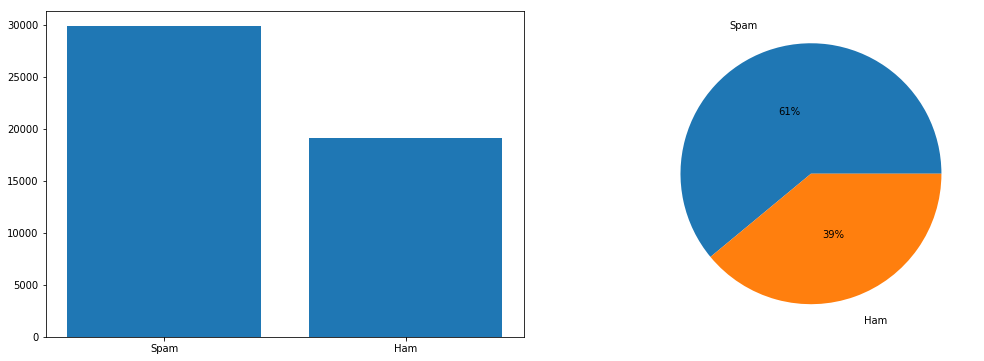

In [18]:
print(dfMaster['isSpam'].value_counts().rename({False: 'Ham', True: 'Spam'}))


fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,2, wspace =0.1)
barPlt = fig.add_subplot(grid[0,0])
piePlt = fig.add_subplot(grid[0,1])


barPlt.bar(
    ('Spam', 'Ham'), 
    [len(dfMaster[dfMaster['isSpam'] == True]), len(dfMaster[dfMaster['isSpam'] == False])], 
    align='center')
barPlt.set_xticks(np.arange(2), ['Spam', 'Ham'])


piePlt.pie(dfMaster['isSpam'].value_counts(), labels=['Spam', 'Ham'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)


plt.show()

#### conclusion

The objective of this project it's create a algorithm capable to classify if a email is a spam and having a evenly proportion of email can helps in the training and reduce the changes of miss classification.

The ham and spam email doesn't have a perfect even proportion (61 by 39), the difference between them represent 22% from the total of emails. 

The differences seems to be moderate to low and for this case it is being assumed won't cause a significant difference in the model.

This project will use differents types of models and one of those types will considere the relative frequence what will solve this problem and the comparison between models can explain if this distribution is causing effect or not.

## -- Message Type

messageType            isSpam
multipart/alternative  True       6564
multipart/mixed        True       1709
multipart/report       True         70
text/html              True      16431
text/plain             False     19079
                       True       5075
dtype: int64
isPlain  isSpam
False    True      24774
True     False     19079
         True       5075
dtype: int64


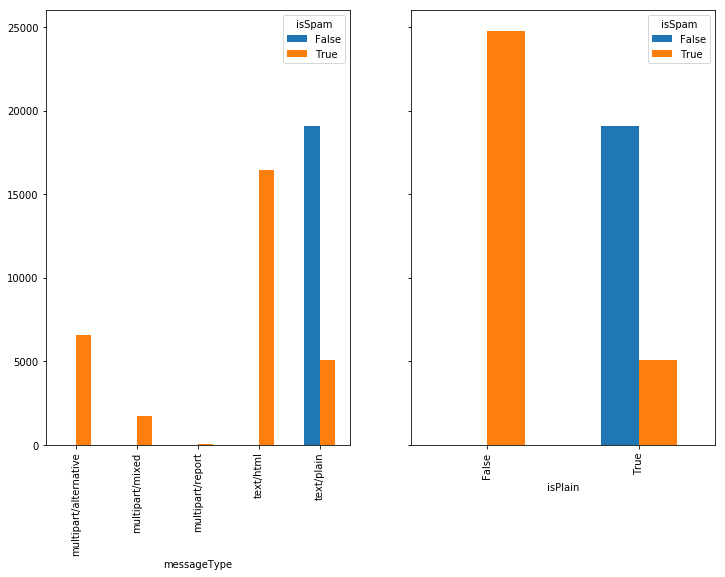

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

dfGroup = dfMaster.groupby(['messageType', 'isSpam']).size()
print(dfGroup)
dfGroup.unstack().plot(kind='bar', legend=True, ax= axs[0])


dfMaster['isPlain'] = dfMaster['messageType'].apply(lambda x : True if x == 'text/plain' else False)

dfGroup = dfMaster.groupby(['isPlain', 'isSpam']).size()
print(dfGroup)
dfGroup.unstack().plot(kind='bar', legend=True, ax= axs[1])

#### Conclusion

The email content can contain html elements, images, attachemnts, plain text or a mix of everthing and it is classify in content types, like text/plain, text/html, multipart/alternative... 

The comparison between the content type and spam resulted in **all ham email is text/plain but not all text/plain is ham** and because of this deduction, all the types was divided between is text plain or not.

This treatement has the objective to simplfy the model.


## -- Day Hour

In [20]:
#Convert Date to a date time object
dfMaster['date'] = dfMaster['date'].apply(lambda x : str(x)).apply(lambda x : None if x == 'nan' else datetime.datetime.strptime(x, '%a, %d %b %Y %H:%M:%S %z'))
#Create a Hour Column
dfMaster['hour'] = dfMaster['date'].apply(lambda x : None if x == None else x.hour)

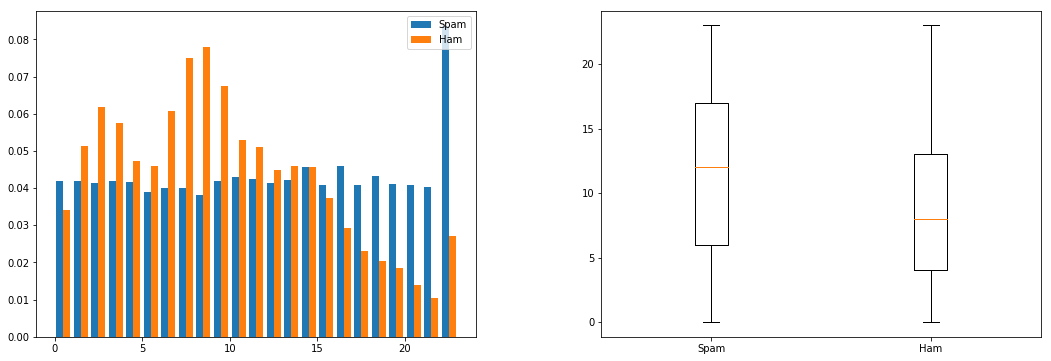

In [21]:
fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
histPlt = fig.add_subplot(grid[0,0:2])
boxPlt1 = fig.add_subplot(grid[0,2:4])

histPlt.hist(
    [
        dfMaster[dfMaster['isSpam'] == True]['hour'].dropna(), 
        dfMaster[dfMaster['isSpam'] == False]['hour']
    ], 
    np.linspace(0, dfMaster['hour'].max(), 24), 
    density = True, 
    label=['Spam', 'Ham']
) 
histPlt.legend(loc='upper right')

boxPlt1.boxplot(
    (
        dfMaster[dfMaster['isSpam'] == True]['hour'].dropna(),
        dfMaster[dfMaster['isSpam'] == False]['hour']
    ), 
    labels = ('Spam', 'Ham')
)


plt.show()

#### Conclusion

The objective of this analyse is to find a relation between the period of the day the user receive the email and the email type and because of that, the time zone was disconsidereing during the cleaning.


The ham email is more frequently sent during the firsts hours of the morning (between 8-10 am) and has the day pass, the amount of email sent decrease, having another small pick around of 3 am.

The spam email seems to have the same proportion during all day except at midnight when it shows a huge pick.

## -- How many person this email was send TO 

In [22]:
#Create a count to
dfMaster['toCount'] = dfMaster['to'].str.split(',').apply(lambda x : len(x) if isinstance(x, list) else 0)

### --- Description for send to

In [23]:
dfMaster['toCount'].describe()

count    48928.000000
mean         3.165284
std         13.404586
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        595.000000
Name: toCount, dtype: float64

### --- Description for send to for more than one

In [24]:
dfMaster[dfMaster['toCount'] > 1]['toCount'].describe()

count    8038.000000
mean       14.333167
std        30.731960
min         2.000000
25%         3.000000
50%         6.000000
75%        12.000000
max       595.000000
Name: toCount, dtype: float64

### --- Proportion direct email and group email

1       39661
2-15     7678
15+      1589
Name: toCountG2, dtype: int64


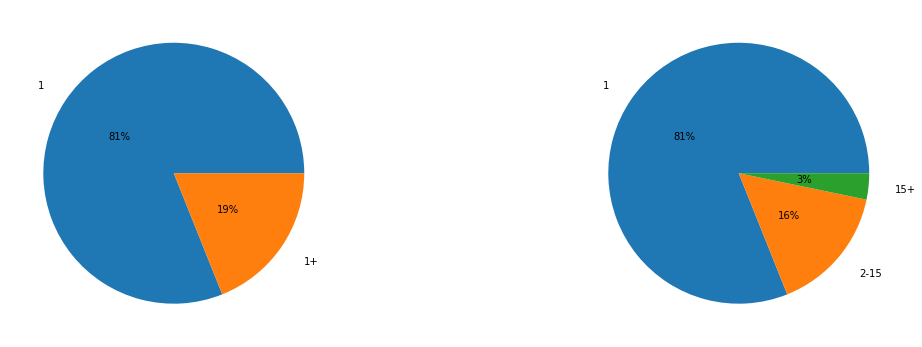

In [25]:
dfTemp = dfMaster.loc[:, ['toCount', 'isSpam']]
dfTemp['toCountG1'] = dfTemp['toCount'].apply(lambda x : '1' if x == 1 else '1+')
dfTemp['toCountG2'] = dfTemp['toCount'].apply(lambda x : '1' if x == 1 else ('15+' if x > 15 else '2-15'))

print(dfTemp['toCountG2'].value_counts())

fig = plt.figure(figsize = (18,6))
grid = plt.GridSpec(1,4, wspace =0.8)
pie1 = fig.add_subplot(grid[0,0:2])
pie2 = fig.add_subplot(grid[0,2:4])

pie1.pie(dfTemp['toCountG1'].value_counts(), labels=['1', '1+'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)

pie2.pie(dfTemp['toCountG2'].value_counts(), labels=['1', '2-15', '15+'], autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)


plt.show()

### --- Distribution of 'To Group' by Spam

In [26]:
dfMaster['toCountGroup'] = dfMaster['toCount'].apply(lambda x: 'Direct' if x == 1 else ('Small Group' if x < 15 else 'Big Group')) 

In [27]:
dfGroupTo = dfMaster.groupby(['toCountGroup', 'isSpam']).size()
print(dfGroupTo.unstack().columns.values)
dfGT = dfGroupTo.unstack()
dfGT['rateF'] = dfGT[False] / (dfGT[False] + dfGT[True])
dfGT['rateT'] = dfGT[True] / (dfGT[False] + dfGT[True])

dfGT.columns = ['Not Spam', 'Spam', 'Rate Not Spam', 'Rate Spam']

dfGT.head()

[False True]


,Not Spam,Spam,Rate Not Spam,Rate Spam
toCountGroup,,,,
Big Group,1632,63,0.962832,0.037168
Direct,11703,27958,0.295076,0.704924
Small Group,5744,1828,0.758584,0.241416


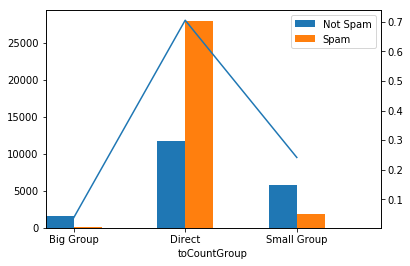

In [28]:
width = .25

dfGT[['Not Spam', 'Spam']].plot(kind='bar')
dfGT['Rate Spam'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-width, len(dfGT)-width])
ax.set_xticklabels(dfGT.index.values)
ax.set_xlabel('Groups')
plt.show()

#.plot(kind='bar', legend=False)

#### Conclusion

A email can be sent to one or more people, the reason of this analyse is to find a relation betweent it and the type of email. 

This variable, already starts with a issue, becasue there is two ways to include a person in a email, it can be occult and/or normal, in case of it being occult, this information will be missing.

In the first stage was found 81% of the email from our dataset was send to one person, 16% between 2 and 15 people and 3 % for more than 15 people

It was expected spam emails to be sent to more than one person, but in this analyse, Spam email has a bigger rate for one person as the ham email is the opposite, and this maybe can be explian by the copy occulty and/or the new technologies who try send a spam email more personalised with a few user info inside and the fact of this dataset comes from a company emails and very offeten employee send email to multiples people to keep a all the sector inform.


## -- Compare email message lenght for ham and spam  

In [87]:
# Count total character in the email message
dfMaster['textLen'] = dfMaster['messageStr'].apply(lambda x : len(str(x)))

#Apply cleaning method
dfMaster['treatedMessage'] = dfMaster['messageStr'].apply(emailTextCleanner)

#Remove stop words
stop = txt.ENGLISH_STOP_WORDS
dfMaster['treatedMessage'] = dfMaster['treatedMessage'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

stop = stopwords.words('english')
dfMaster['treatedMessage'] = dfMaster['treatedMessage'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Count total character in the treated email message
dfMaster['treatedTextLen'] = dfMaster['treatedMessage'].apply(lambda x : len(x)) 

#Create a column with list of words
dfMaster['wordsList'] = dfMaster['treatedMessage'].str.split().apply(lemmatizeList).apply(revomeWordsWithOneCharacter)

#Create a columns to calculate the total amount of words
dfMaster['totalTreatedWords'] = dfMaster['wordsList'].apply(lambda x : len(x))

# count the total unique words
dfMaster['uniqueWordsLen'] = dfMaster['wordsList'].apply(lambda x : len(set(x)))


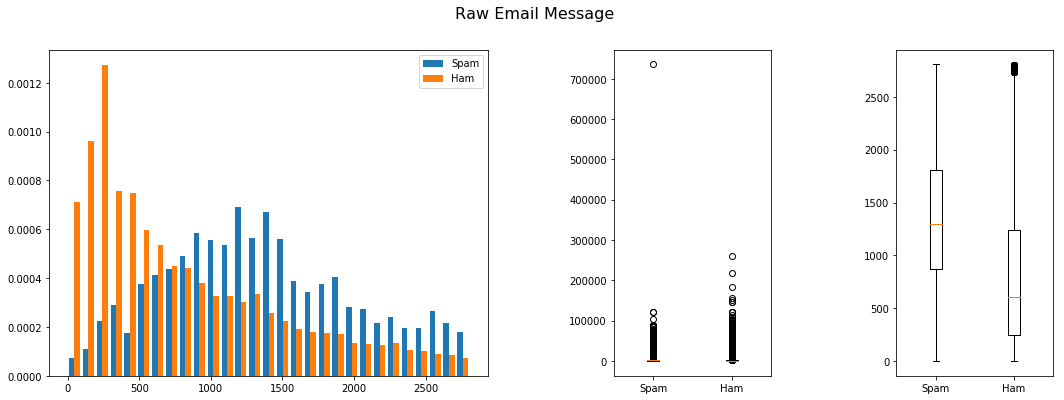

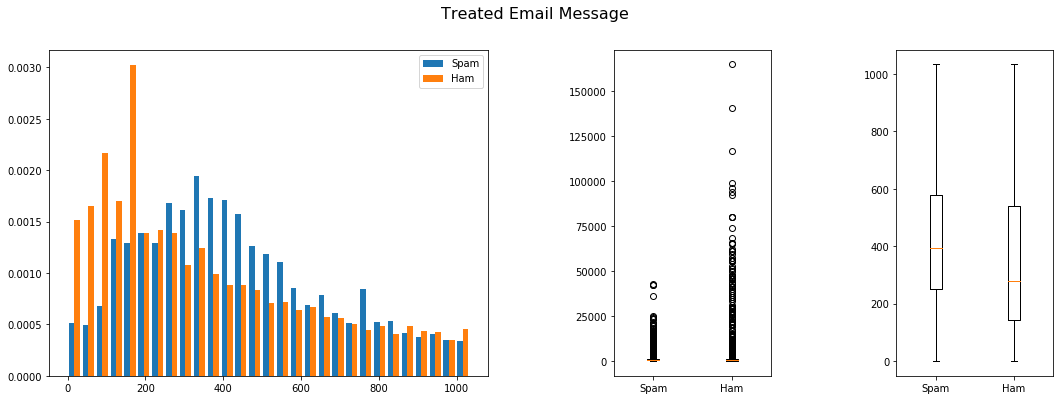

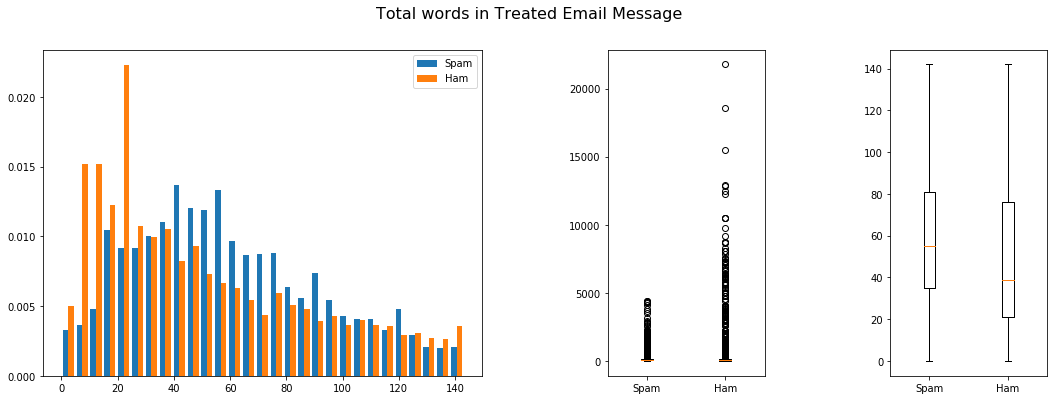

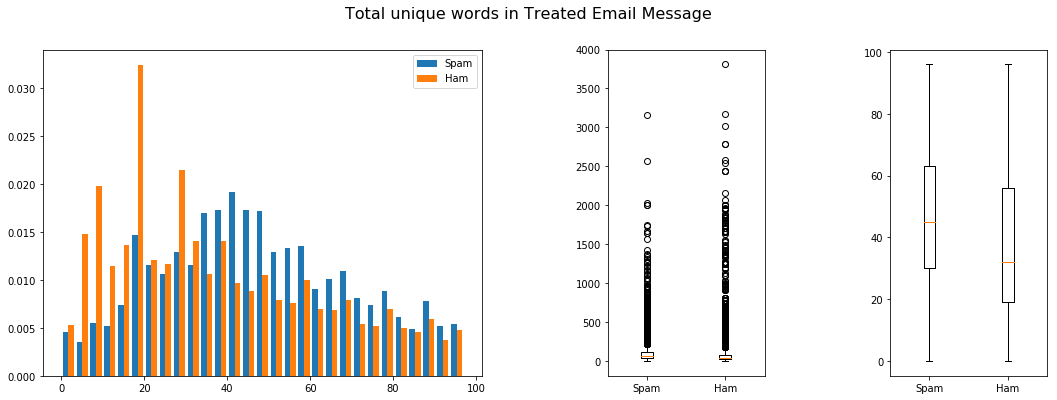

In [92]:
createPlotLenghtDist('textLen', dfMaster, "Raw Email Message") 

createPlotLenghtDist('treatedTextLen', dfMaster, "Treated Email Message")

createPlotLenghtDist('totalTreatedWords', dfMaster, "Total words in Treated Email Message")

createPlotLenghtDist('uniqueWordsLen', dfMaster, "Total unique words in Treated Email Message")

#### Conclusion


Emails are a text and all the text has a total number of words and a total of number of characters and this analyse has a intention to find a relation between the text size and the email type. 

To calculate the text size was used 4 different logics:

- **First**: The text size whitout any treatement
It consist in count the total of characters of the raw data. 
Nothing was removed. 

- **Second**: The text size after treatement
It consist in count the total of characters after removing break lines, html tags, digit, stop words, extra space, break lines and some commom words.

- **Third**: Total words after treatment
It consist in removing the words with one charater, lemmatize the words and count the total of words after it. 

- **Fourth**: Total words after treatment
It consist in count the total unique of words from the thid case.


All the four logics present the same result.

Usualy, the total words in the ham email is between 10 and 40 words as the spam email is between 30 and 80.

In other owthers, spam emails are usualy bigger than ham email


## -- Words distribution on Email Message 

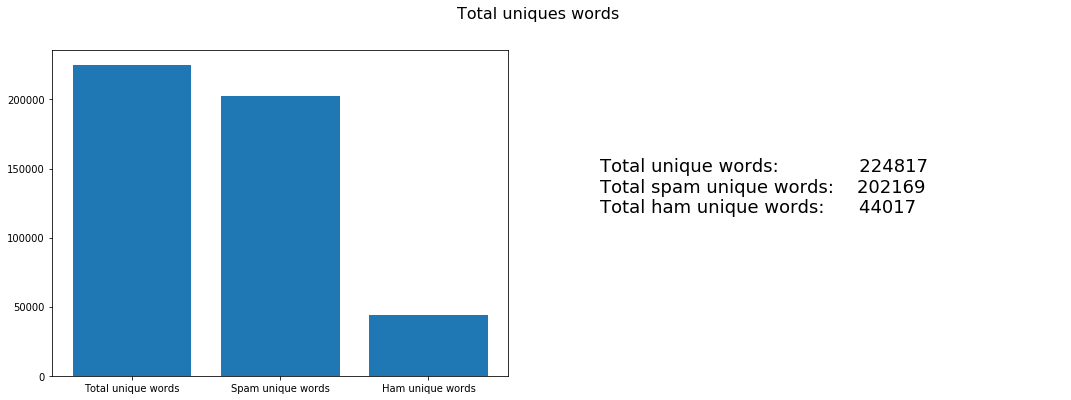

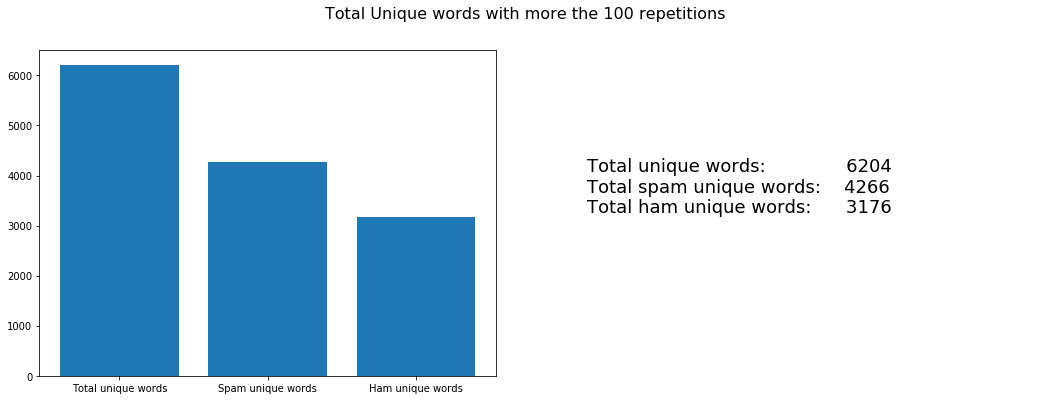

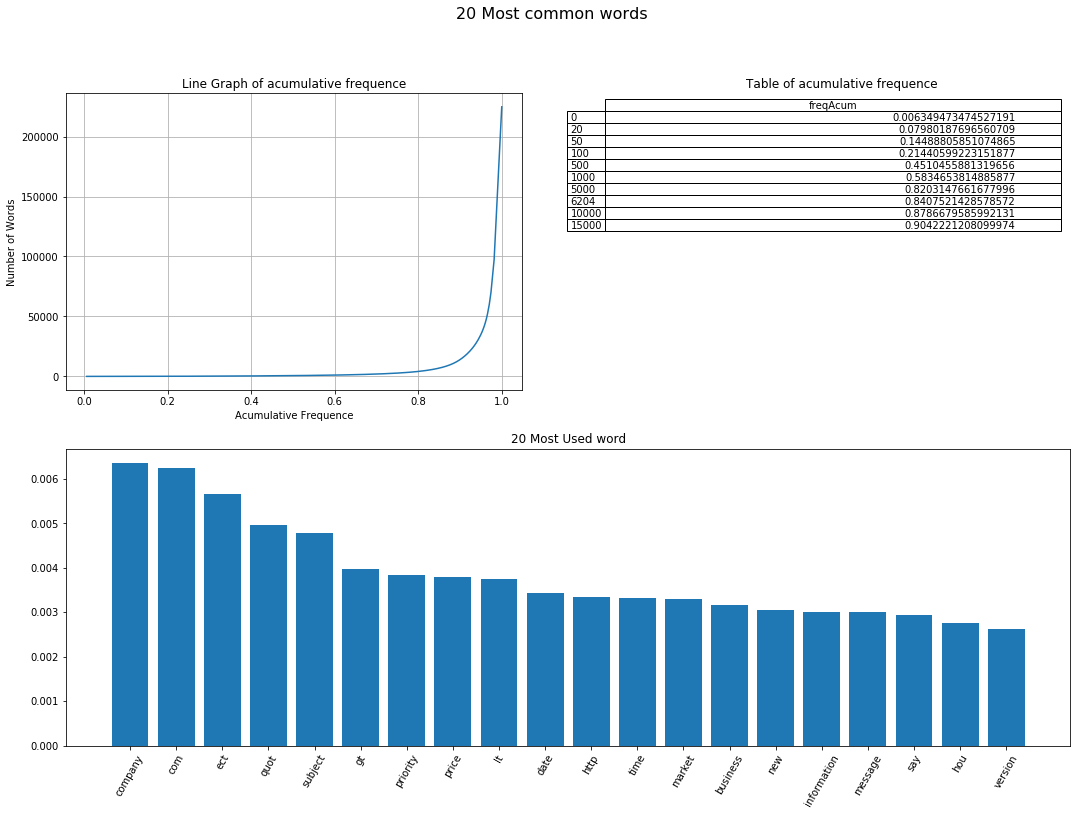

In [126]:
count = Counter(list(chain(*dfMaster["wordsList"].values)))

countSpam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == True]["wordsList"].values)))

countHam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == False]["wordsList"].values)))

totalUniqueWordsPlot(len(count), len(countSpam), len(countHam), "Total uniques words")

dfCounter = pd.DataFrame.from_dict(data = dict(count),orient='index', columns = ['freq'])

dfCounterSpam = pd.DataFrame.from_dict(data = dict(countSpam),orient='index', columns = ['freq'])

dfCounterHam = pd.DataFrame.from_dict(data = dict(countHam),orient='index', columns = ['freq'])

totalUniqueWordsPlot(
    len(dfCounter[dfCounter['freq'] > 100]),
    len(dfCounterSpam[dfCounterSpam['freq'] > 100]),
    len(dfCounterHam[dfCounterHam['freq'] > 100]), 
    "Total Unique words with more the 100 repetitions")


plot20MostWord(count, "20 Most common words", [6204])

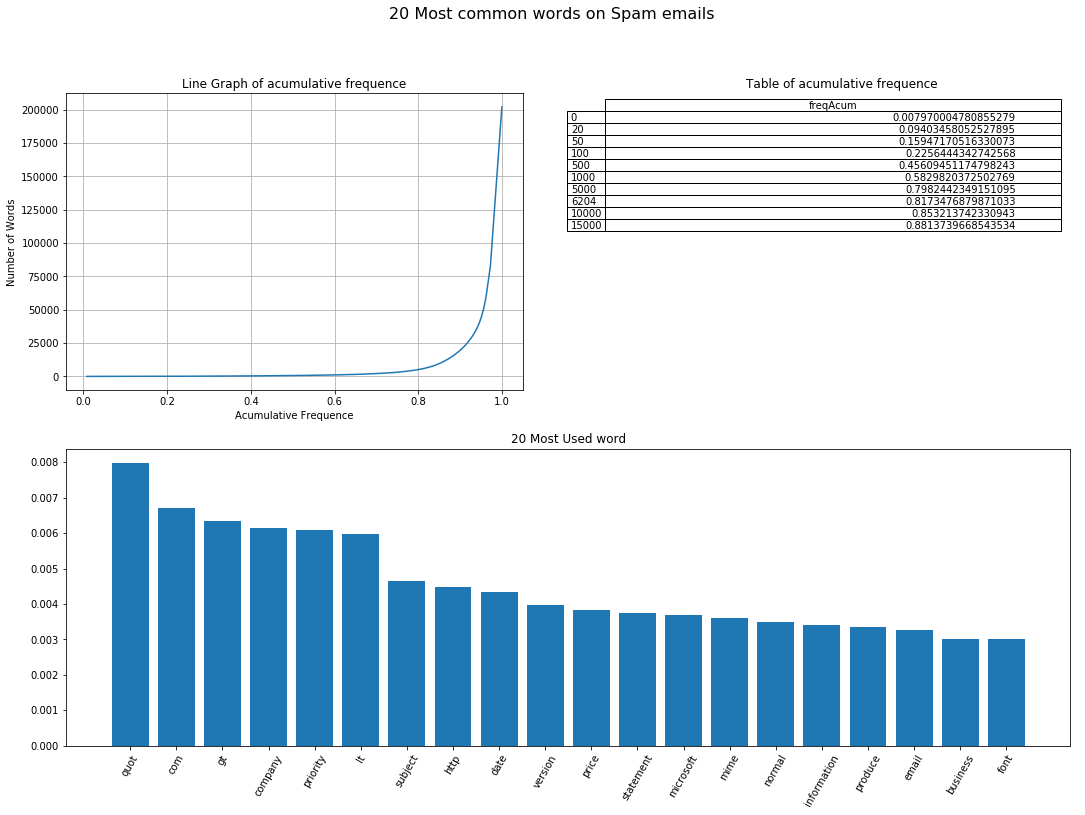

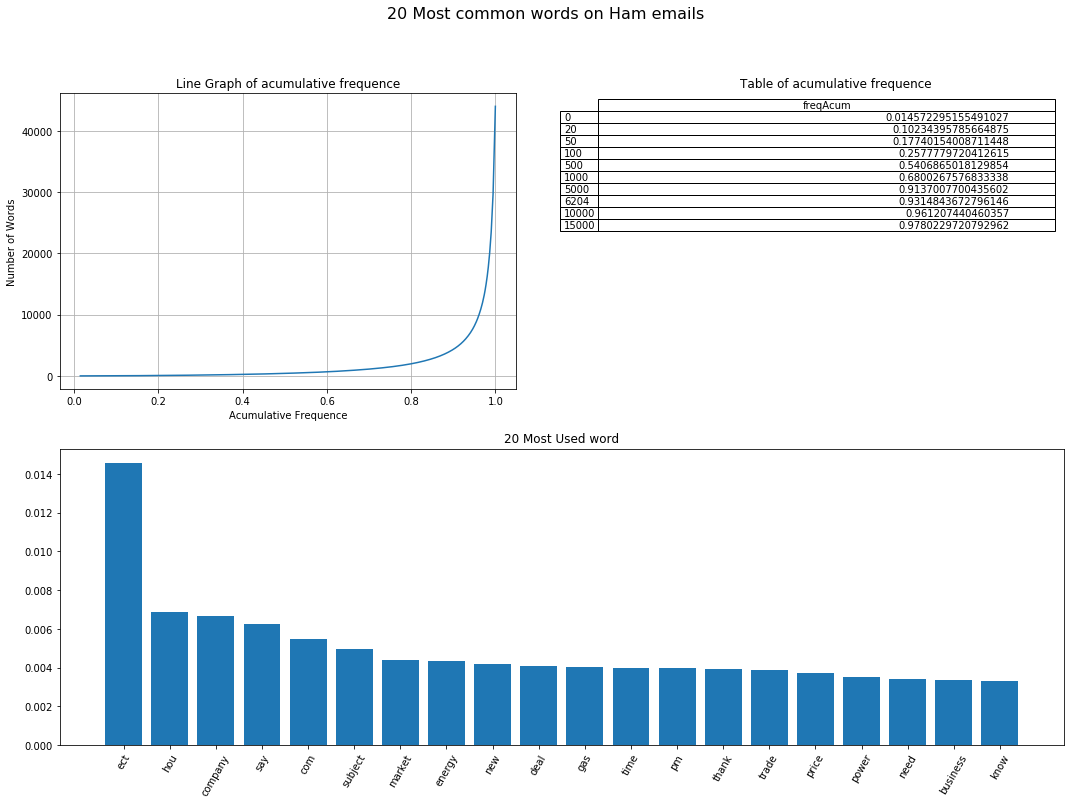

In [127]:

plot20MostWord(countSpam, "20 Most common words on Spam emails", [6204]) 
plot20MostWord(countHam, "20 Most common words on Ham emails", [6204])


#### Conclusion

In this analyse is looking for the most frequent words and how frequently they are, the intention is improve the model precision removing the words less frequently.

There are more than 220 thousand different words, but only 6204 who repeats more than 100 times.
This project is analysing around of 50 thousand email and a word who repeats 100 times, supposing this words is being in 100 different emails, it means, this words is present, at the maximum, in 5% of the emails.

When looking to the accumulative frequency, 6204 words achieve around of 84% of all the frequency, to increse 6% is needed roughly 150% more words, the fact of adding more words, result in add more features to the model and by conseguence more complexity.

The accumulative frequency has a exponetial curve, where after a point to obtein better result needs too much, in the reason to find the better cost benefit, it's recomend get the curve point. In this case 6204. 

FYI: To find the accumulative frenquency was calculated the frequency of each word and then sorted to the biggest frequency to the smallest.

## -- Text Lenght analyse for subject

In [128]:
dfMaster['subLen'] = dfMaster['subject'].apply(lambda x : len(str(x)))

#Apply cleaning method
dfMaster['treatedSub'] = dfMaster['subject'].apply(emailTextCleanner)

#Remove stop words
stop = txt.ENGLISH_STOP_WORDS
dfMaster['treatedSub'] = dfMaster['treatedSub'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

stop = stopwords.words('english')
dfMaster['treatedSub'] = dfMaster['treatedSub'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

dfMaster['treatedSubLen'] = dfMaster['treatedSub'].apply(lambda x : len(x))


#Create a column with list of words
dfMaster['subWordsList'] = dfMaster['treatedSub'].str.split().apply(lemmatizeList).apply(revomeWordsWithOneCharacter)

#Create a columns to calculate the total amount of words
dfMaster['totalTreatedSubWords'] = dfMaster['subWordsList'].apply(lambda x : len(x))

dfMaster['uniqueSubWordsLen'] = dfMaster['subWordsList'].apply(lambda x : len(set(x)))

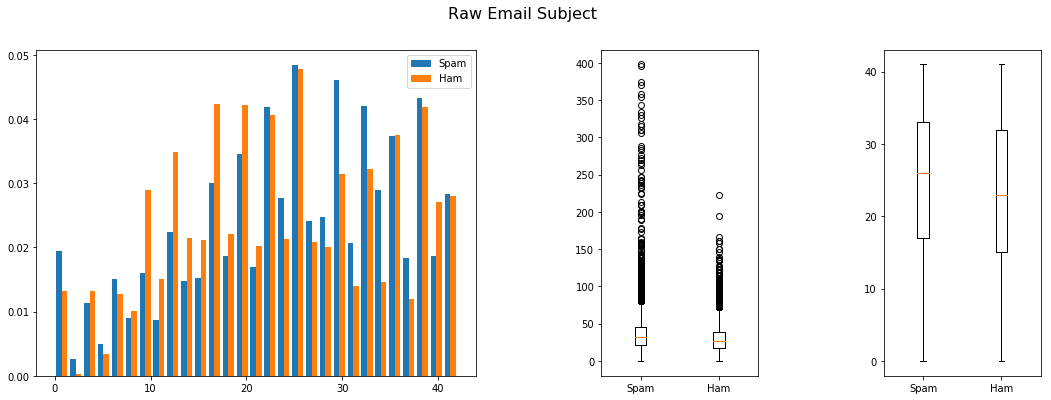

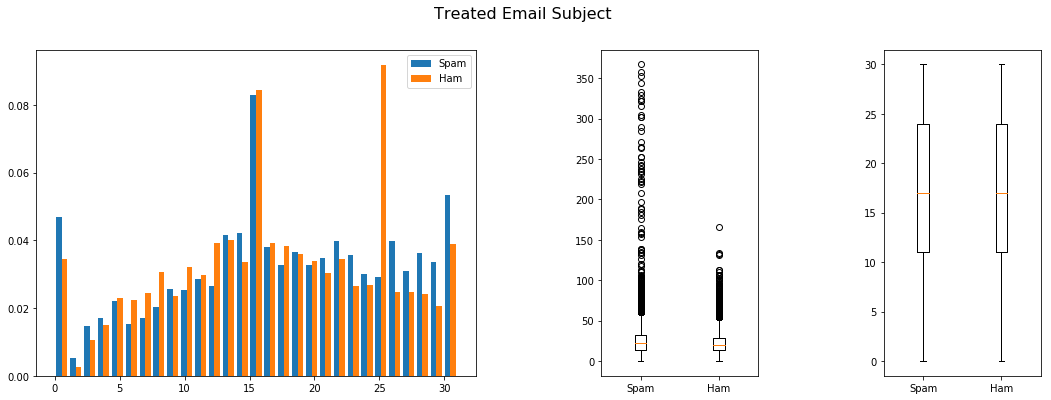

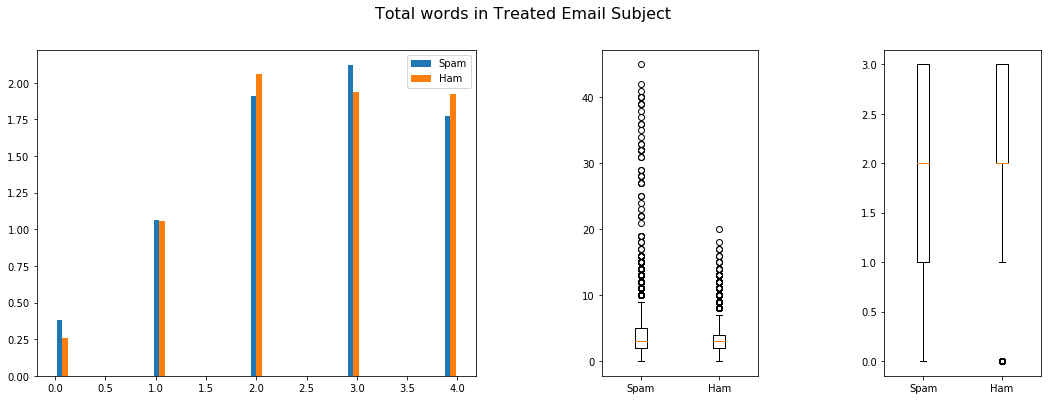

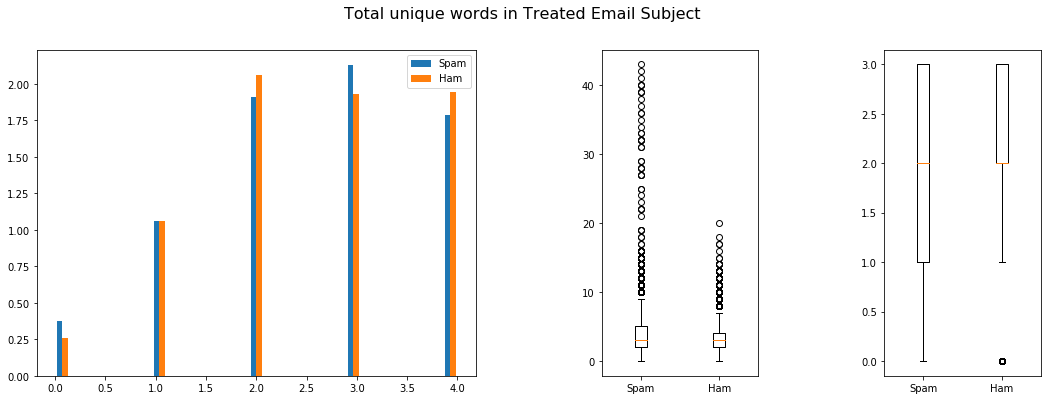

In [129]:
createPlotLenghtDist('subLen', dfMaster, "Raw Email Subject")

createPlotLenghtDist('treatedSubLen', dfMaster, "Treated Email Subject")

createPlotLenghtDist('totalTreatedSubWords', dfMaster, "Total words in Treated Email Subject")

createPlotLenghtDist('uniqueSubWordsLen', dfMaster, "Total unique words in Treated Email Subject")


#### Conclusion

Emails subjects are a text and all the text has a total number of words and a total of number of characters and this analyse has a intention to find a relation between the text size and the email type.

The logic used to analyse was the same as email message.

The spam and ham email seems to have the same behavior in all logics applied. It can be caused by the email subject definition.

Email subject are a short message what represent the general idea of the email content.

## -- Email Subject Words Visualization

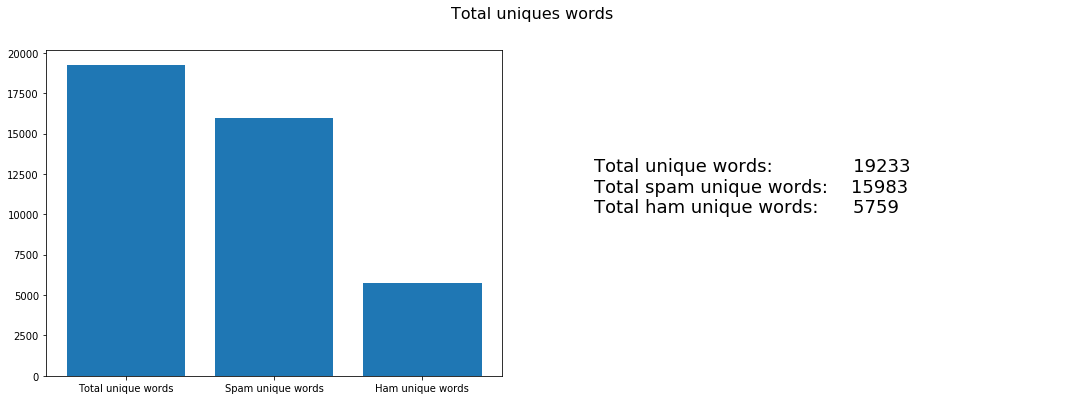

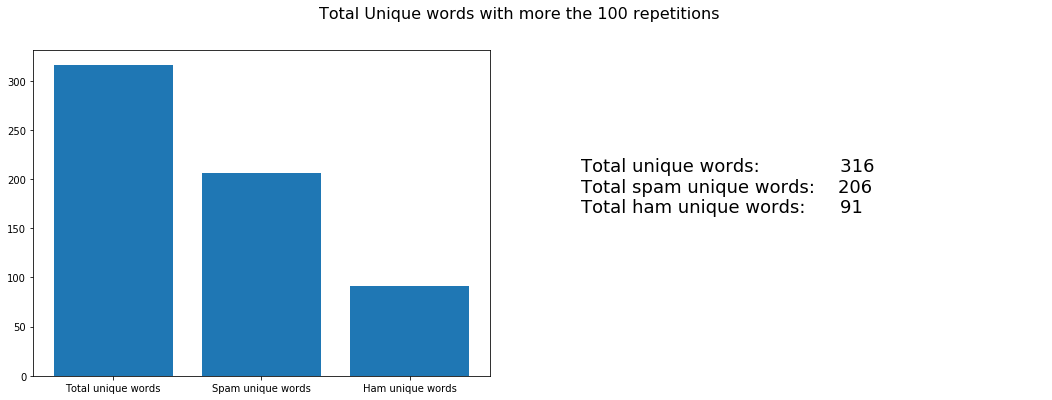

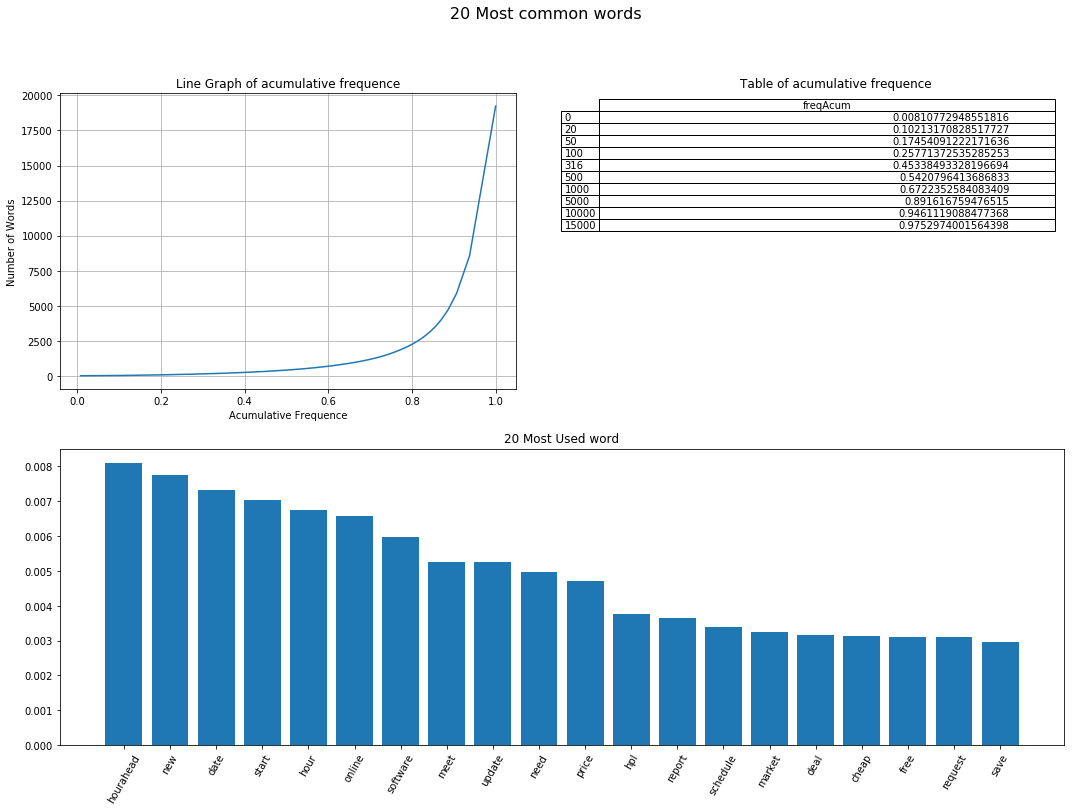

In [130]:
subCount = Counter(list(chain(*dfMaster["subWordsList"].values)))

subCountSpam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == True]["subWordsList"].values)))

subCountHam = Counter(list(chain(*dfMaster[dfMaster['isSpam'] == False]["subWordsList"].values)))

totalUniqueWordsPlot(len(subCount), len(subCountSpam), len(subCountHam), "Total uniques words")


dfSubCounter = pd.DataFrame.from_dict(data = dict(subCount),orient='index', columns = ['freq'])

dfSubCounterSpam = pd.DataFrame.from_dict(data = dict(subCountSpam),orient='index', columns = ['freq'])

dfSubCounterHam = pd.DataFrame.from_dict(data = dict(subCountHam),orient='index', columns = ['freq'])

totalUniqueWordsPlot(
    len(dfSubCounter[dfSubCounter['freq'] > 100]),
    len(dfSubCounterSpam[dfSubCounterSpam['freq'] > 100]),
    len(dfSubCounterHam[dfSubCounterHam['freq'] > 100]),
    "Total Unique words with more the 100 repetitions")

plot20MostWord(subCount, "20 Most common words", [316])


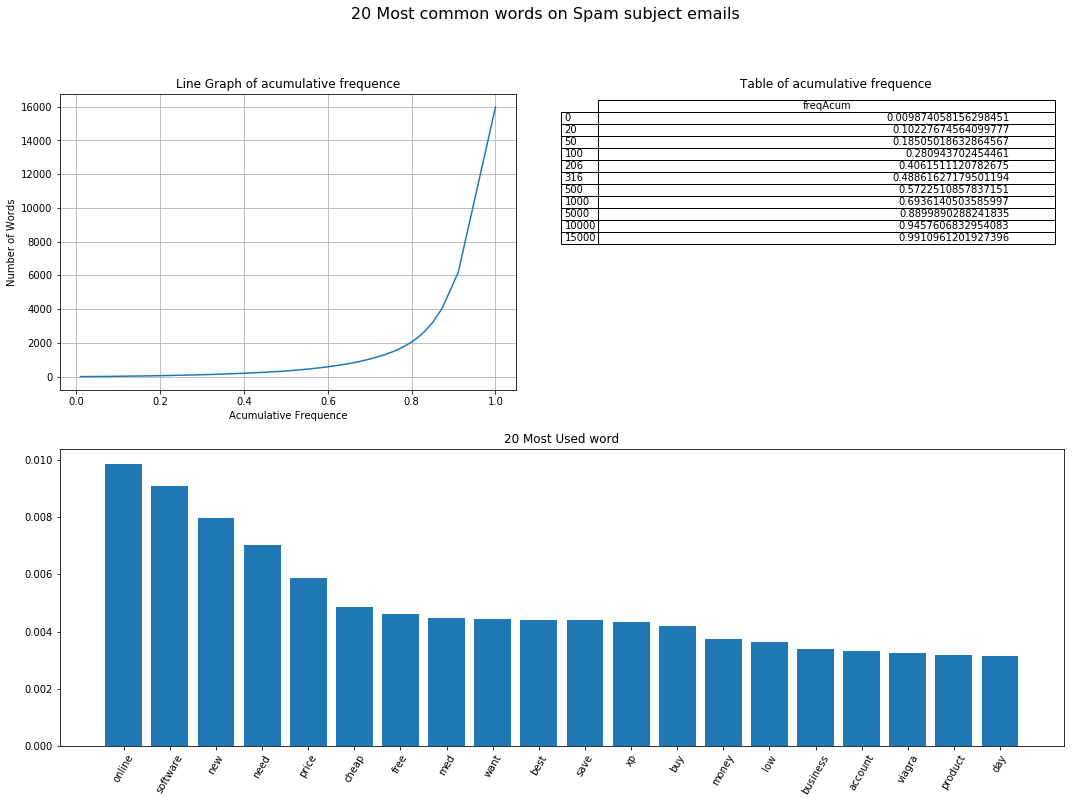

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:174: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


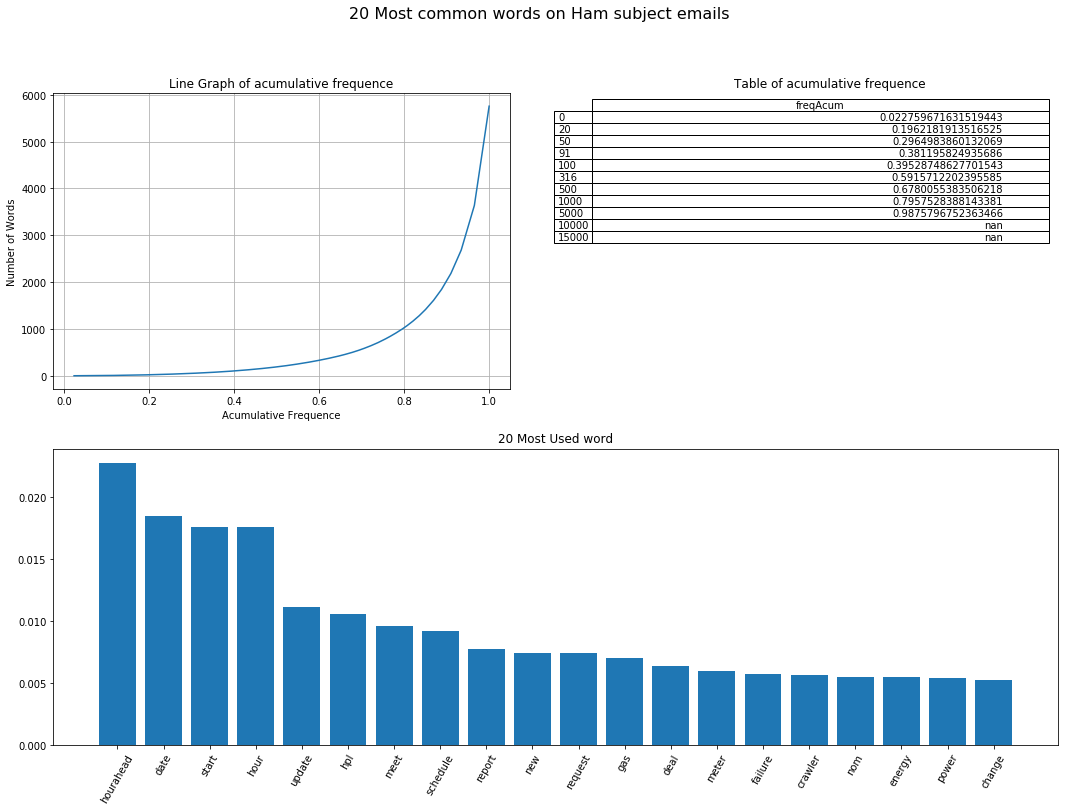

In [132]:
plot20MostWord(subCountSpam, "20 Most common words on Spam subject emails", [316, 206])
plot20MostWord(subCountHam, "20 Most common words on Ham subject emails", [316, 91])

### Conclusion

In this analyse is looking for the most frequent words and how frequently they are, the intention is improve the model precision removing the words less frequently.

There are more than 19 thousand different words, but only 316 who repeats more than 100 times.
This project is analysing around of 50 thousand email and a word who repeats 100 times, supposing this words is being in 100 different emails subjects, it means, this words is present, at the maximum, in 5% of the emails.

When looking to the accumulative frequency, 316 words achieve around of 45% of all the frequency, to achieve 70% is needed roughly 300% more words and 80% is 800% more words.

In other words, the words email subject doesn't reapeat so offten, only 1.6% of the words are present in more than 5% of emails.

The spam emails needs 2000 different words to achieve 80% of the spam email frequence, as the Ham email needs 1000 and all type emails needs 2500.
In resume, around of 12.5% of words is needed to achieve 80% of the frequence


FYI: To find the accumulative frenquency was calculated the frequency of each word and then sorted to the biggest frequency to the smallest.

## Forward email distribution by spam and ham

In [56]:
dfMaster['containFW'] = dfMaster['subject'].apply(lambda x : True if "FW:" in str(x) else False)

False    47517
True      1411
Name: containFW, dtype: int64


([<matplotlib.patches.Wedge at 0x7f342f9ea128>,
 [Text(-1.195078556186357, 0.10856907728967854, 'False'),
  Text(1.1950785619041513, -0.10856901435080599, 'True')],
 [Text(-0.4979493984109821, 0.04523711553736606, '97%'),
  Text(0.4979494007933964, -0.04523708931283583, '3%')])

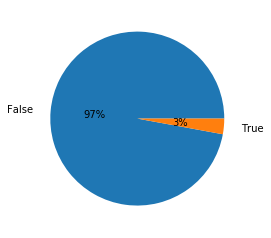

In [57]:
print(dfMaster['containFW'].value_counts())

plt.pie(dfMaster['containFW'].value_counts(), labels=dfMaster['containFW'].unique(), autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)

In [58]:
dfGroupTo = dfMaster.groupby(['containFW', 'isSpam']).size()
print(dfGroupTo.unstack().columns.values)
dfGT = dfGroupTo.unstack()
dfGT['rateF'] = dfGT[False] / (dfGT[False] + dfGT[True])
dfGT['rateT'] = dfGT[True] / (dfGT[False] + dfGT[True])

dfGT.columns = ['Not Spam', 'Spam', 'Rate Not Spam', 'Rate Spam']

dfGT.head()



[False True]


,Not Spam,Spam,Rate Not Spam,Rate Spam
containFW,,,,
False,17765,29752,0.373866,0.626134
True,1314,97,0.931254,0.068746


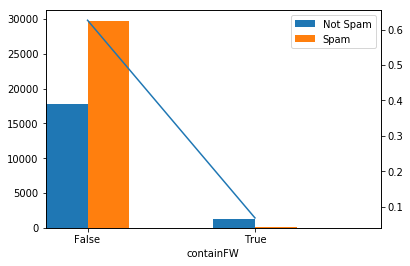

In [59]:
width = .25

dfGT[['Not Spam', 'Spam']].plot(kind='bar')
dfGT['Rate Spam'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-width, len(dfGT)-width])
ax.set_xticklabels(dfGT.index.values)
ax.set_xlabel('Groups')
plt.show()

## Response email distribution by spam and ham

In [60]:
dfMaster['containRE'] = dfMaster['subject'].apply(lambda x : True if "RE:" in str(x) else False)

False    47361
True      1567
Name: containRE, dtype: int64


([<matplotlib.patches.Wedge at 0x7f342f8c1630>,
 [Text(-1.1939311335988065, 0.12053401272449489, 'False'),
  Text(1.1939311350094575, -0.12053399875150764, 'True')],
 [Text(-0.4974713056661694, 0.050222505301872875, '97%'),
  Text(0.49747130625394065, -0.05022249947979485, '3%')])

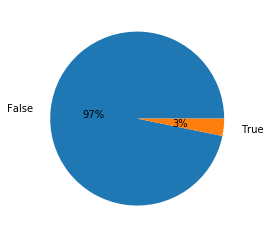

In [61]:
print(dfMaster['containRE'].value_counts())

plt.pie(dfMaster['containRE'].value_counts(), labels=dfMaster['containRE'].unique(), autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)

In [62]:
dfGroupTo = dfMaster.groupby(['containRE', 'isSpam']).size()
print(dfGroupTo.unstack().columns.values)
dfGT = dfGroupTo.unstack()
dfGT['rateF'] = dfGT[False] / (dfGT[False] + dfGT[True])
dfGT['rateT'] = dfGT[True] / (dfGT[False] + dfGT[True])

dfGT.columns = ['Not Spam', 'Spam', 'Rate Not Spam', 'Rate Spam']

dfGT.head()

[False True]


,Not Spam,Spam,Rate Not Spam,Rate Spam
containRE,,,,
False,17781,29580,0.375435,0.624565
True,1298,269,0.828334,0.171666


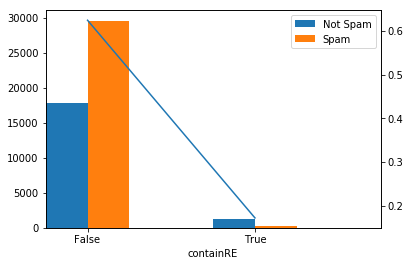

In [63]:
width = .25

dfGT[['Not Spam', 'Spam']].plot(kind='bar')
dfGT['Rate Spam'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-width, len(dfGT)-width])
ax.set_xticklabels(dfGT.index.values)
ax.set_xlabel('Groups')
plt.show()

## Origin Email Server Visualization

In [64]:
dfMaster["orgEmailRoot"] = dfMaster["from"].apply(getEmailRoot)

In [65]:
dfMaster["orgEmailServer"] = dfMaster["orgEmailRoot"].apply(lambda x : getEmailPartRoot(x,1))

## -- Total Unique words

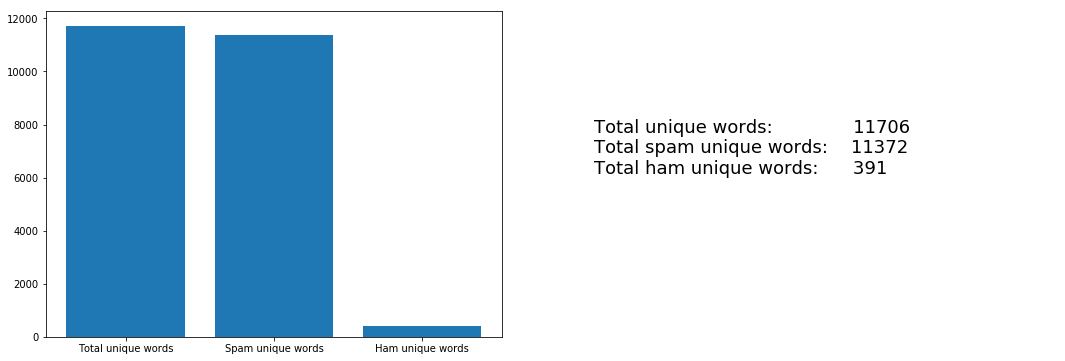

In [66]:
emailServerCount = Counter(list(dfMaster["orgEmailServer"].values))

emailServerCountSpam = Counter(list(dfMaster[dfMaster['isSpam'] == True]["orgEmailServer"].values))

emailServerCountHam = Counter(list(dfMaster[dfMaster['isSpam'] == False]["orgEmailServer"].values))

totalUniqueWordsPlot(len(emailServerCount), len(emailServerCountSpam), len(emailServerCountHam))

## -- Total Unique words with more the 100 repetitions

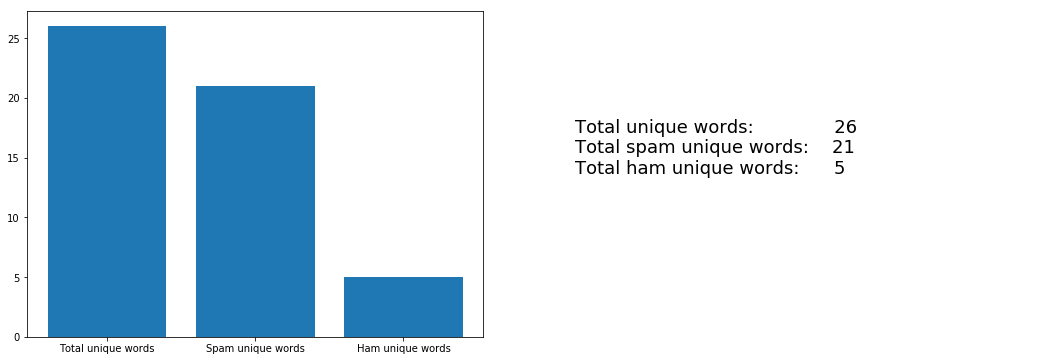

In [67]:
dfEmailServerCounter = pd.DataFrame.from_dict(data = dict(emailServerCount),orient='index', columns = ['freq'])

dfEmailServerCounterSpam = pd.DataFrame.from_dict(data = dict(emailServerCountSpam),orient='index', columns = ['freq'])

dfEmailServerCounterHam = pd.DataFrame.from_dict(data = dict(emailServerCountHam),orient='index', columns = ['freq'])

totalUniqueWordsPlot(
    len(dfEmailServerCounter[dfEmailServerCounter['freq'] > 100]),
    len(dfEmailServerCounterSpam[dfEmailServerCounterSpam['freq'] > 100]),
    len(dfEmailServerCounterHam[dfEmailServerCounterHam['freq'] > 100]))

## -- 20 Most common words

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


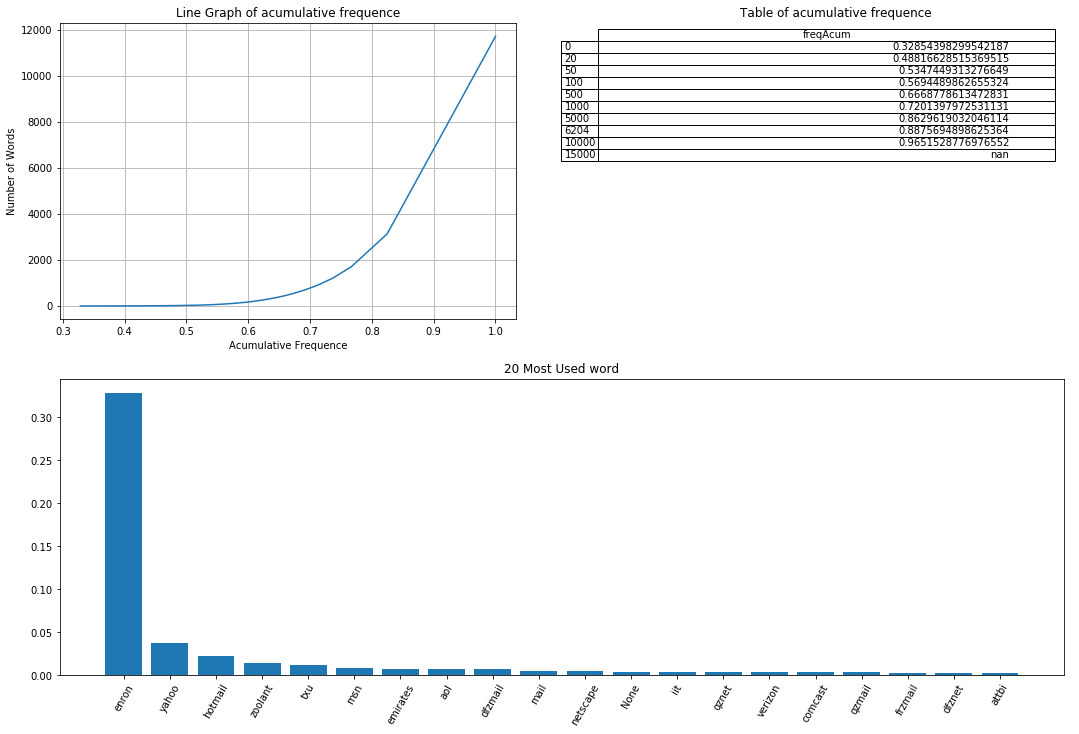

In [68]:
plot20MostWord(emailServerCount) 

## -- 20 Most common words on Spam emails

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


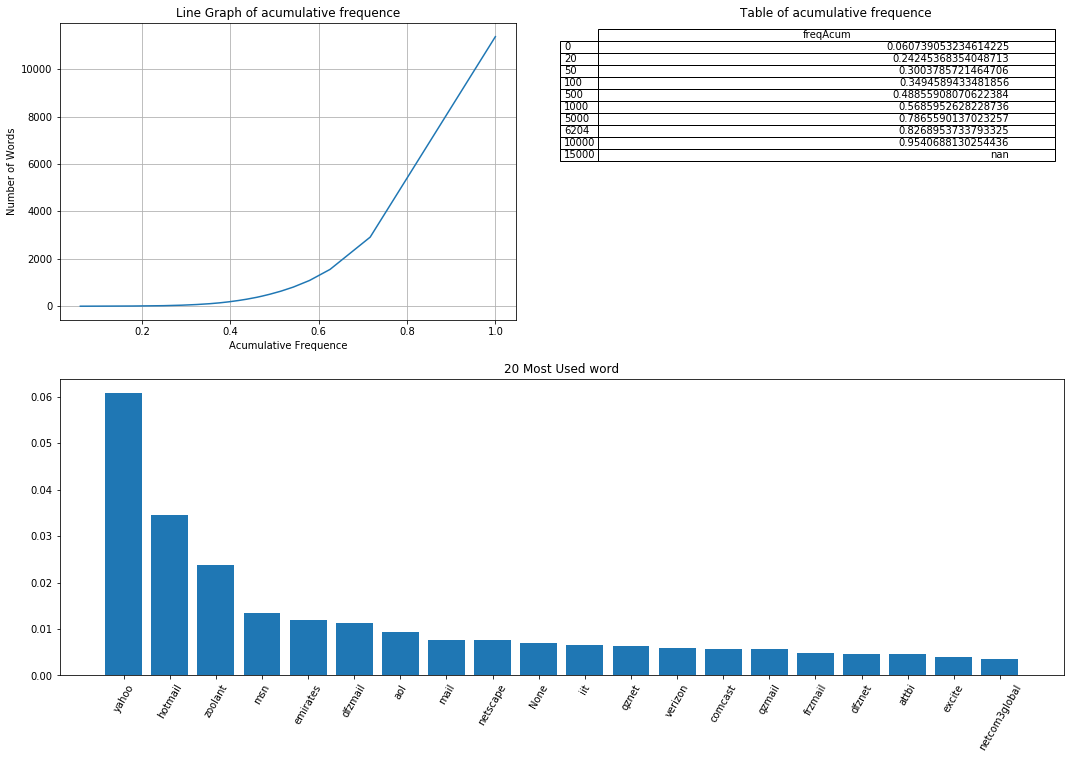

In [69]:
plot20MostWord(emailServerCountSpam) 

## -- 20 Most common words on Ham emails

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


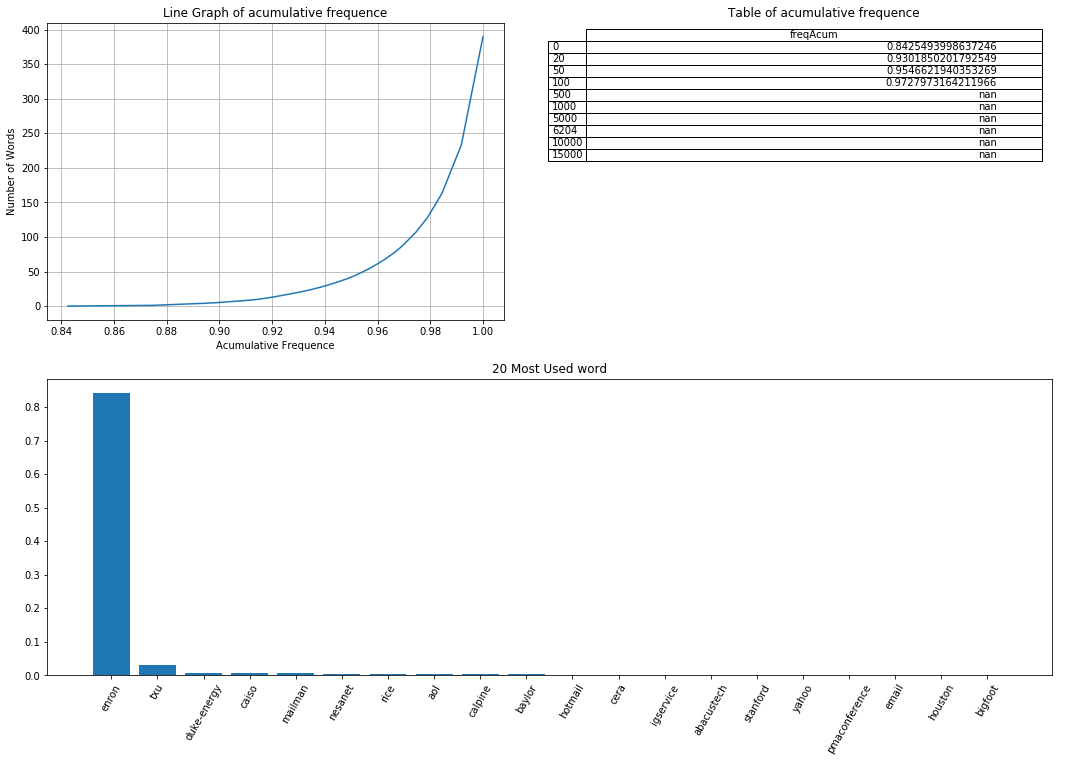

In [70]:
plot20MostWord(emailServerCountHam) 

## Origin Email Name Visualization

In [71]:
dfMaster["orgEmailName"] = dfMaster["orgEmailRoot"].apply(lambda x : getEmailPartRoot(x,0))

## -- Total Unique words

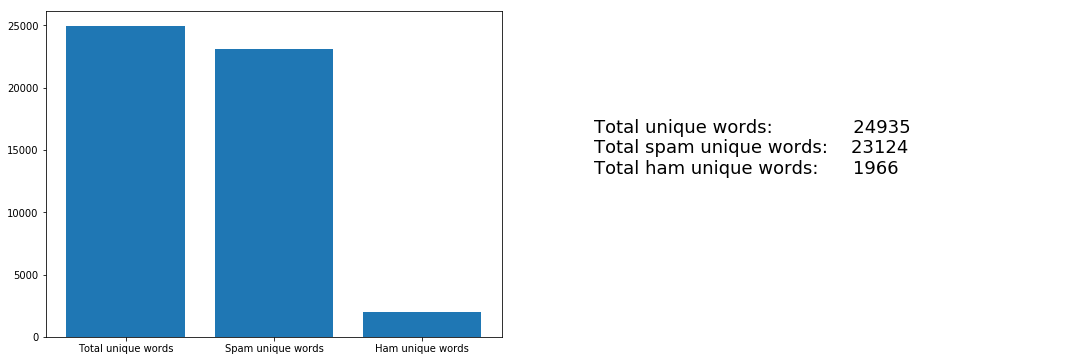

In [72]:
emailNameCount = Counter(list(dfMaster["orgEmailName"].values))

emailNameCountSpam = Counter(list(dfMaster[dfMaster['isSpam'] == True]["orgEmailName"].values))

emailNameCountHam = Counter(list(dfMaster[dfMaster['isSpam'] == False]["orgEmailName"].values))

totalUniqueWordsPlot(len(emailNameCount), len(emailNameCountSpam), len(emailNameCountHam))

## -- Total Unique words with more the 100 repetitions

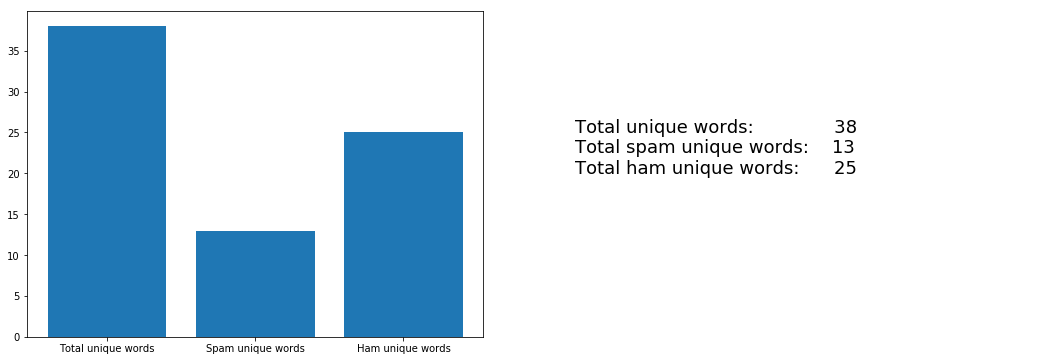

In [73]:
dfEmailNameCounter = pd.DataFrame.from_dict(data = dict(emailNameCount),orient='index', columns = ['freq'])

dfEmailNameCounterSpam = pd.DataFrame.from_dict(data = dict(emailNameCountSpam),orient='index', columns = ['freq'])

dfEmailNameCounterHam = pd.DataFrame.from_dict(data = dict(emailNameCountHam),orient='index', columns = ['freq'])

totalUniqueWordsPlot(
    len(dfEmailNameCounter[dfEmailNameCounter['freq'] > 100]),
    len(dfEmailNameCounterSpam[dfEmailNameCounterSpam['freq'] > 100]),
    len(dfEmailNameCounterHam[dfEmailNameCounterHam['freq'] > 100]))


## -- 20 Most common words

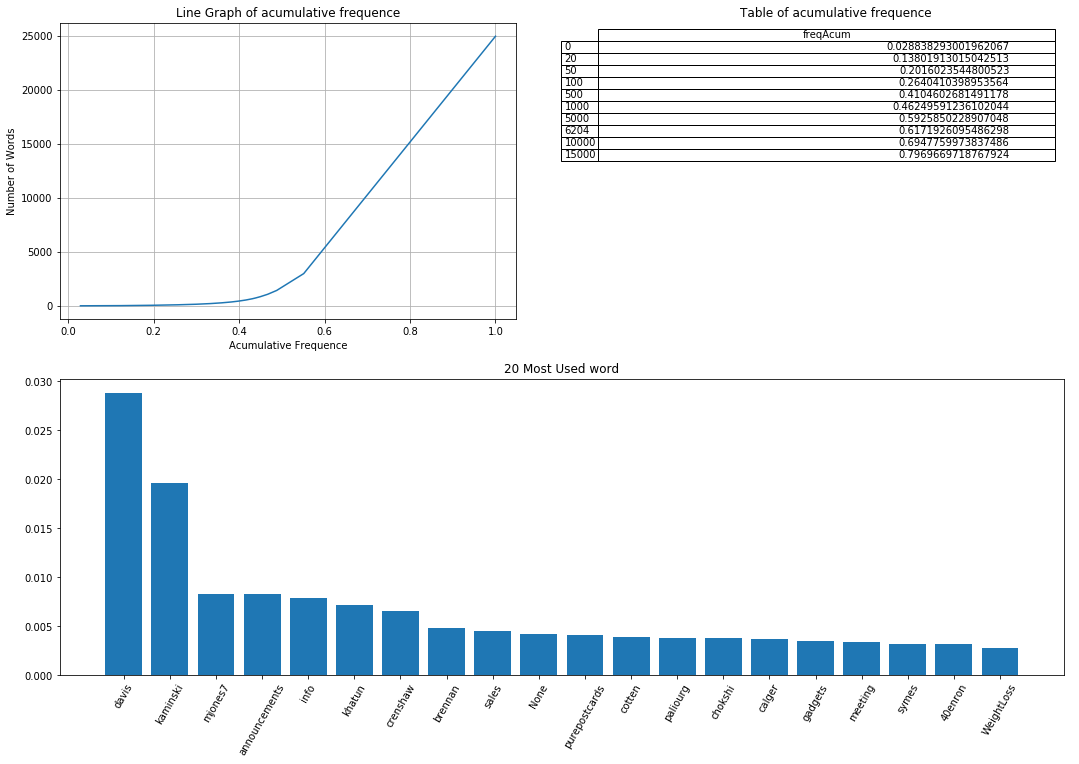

In [74]:
plot20MostWord(emailNameCount) 

## -- 20 Most common words on Spam emails

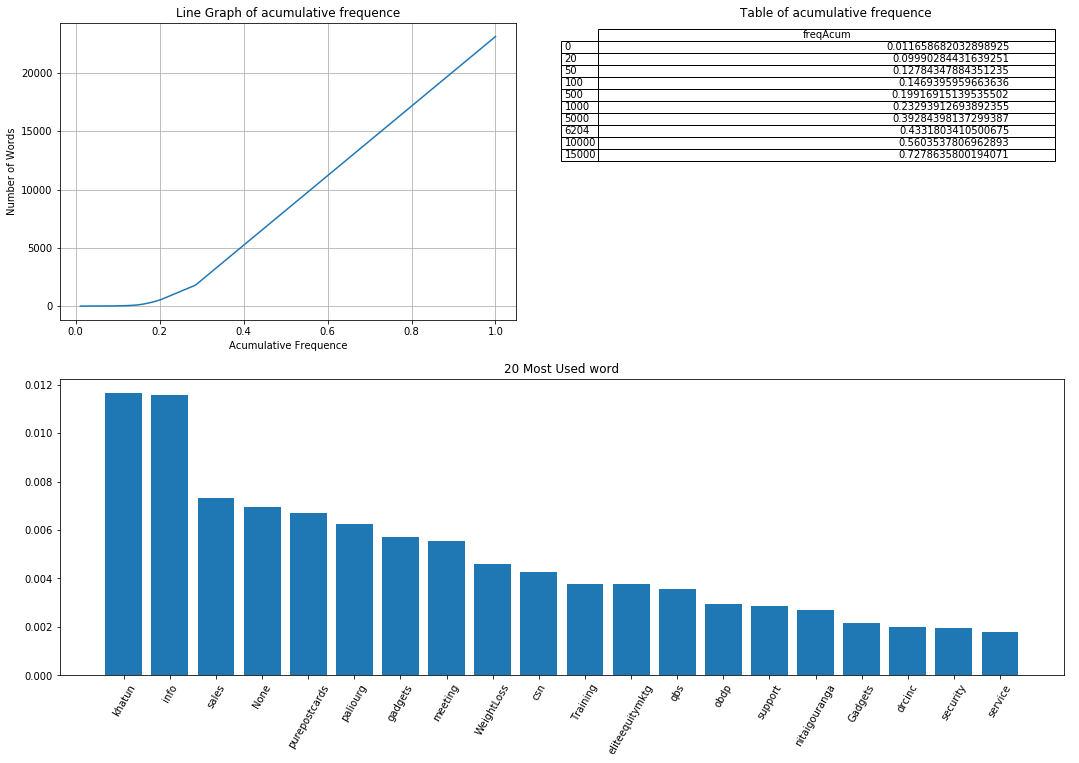

In [75]:
plot20MostWord(emailNameCountSpam)

## -- 20 Most common words on Ham emails

/home/phrc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


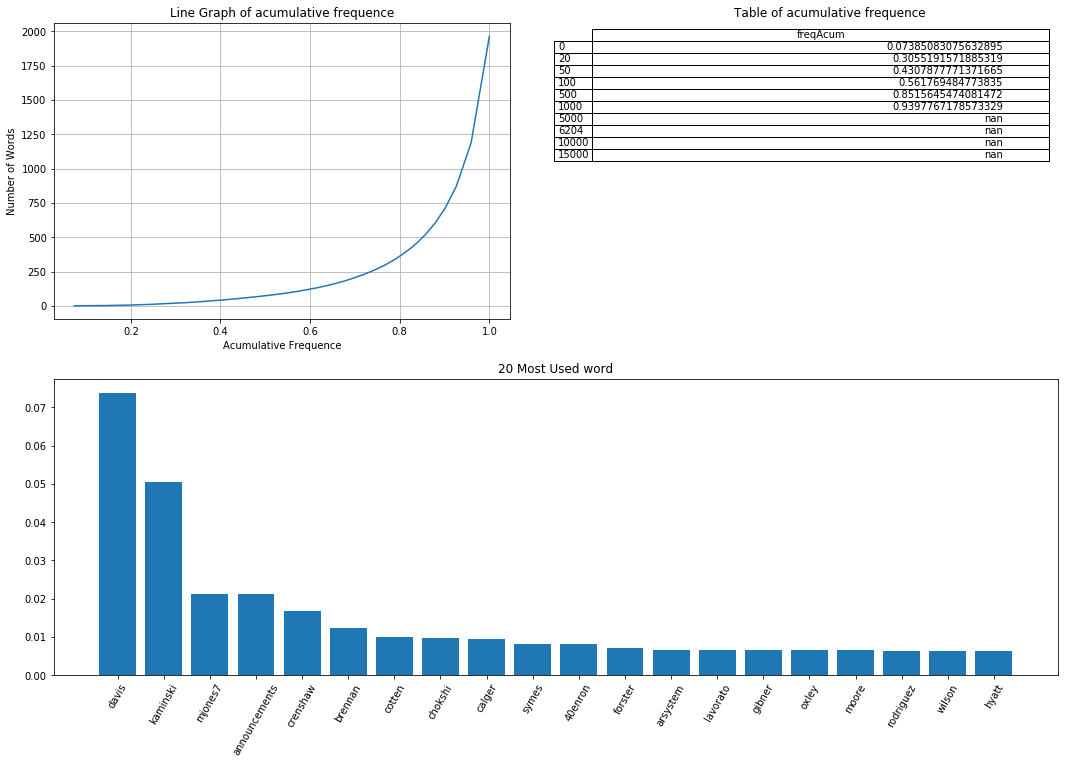

In [76]:
plot20MostWord(emailNameCountHam) 

# Modeling

## -- Create a modeling dataset

In [77]:
dfModeling = dfMaster.loc[:,["isSpam", "hour", "isPlain","toCountGroup", "containFW", "containRE", "orgEmailServer", "orgEmailName", "uniqueSubWordsLen", "uniqueWordsLen",  'subLen', "textLen", 'treatedSub','treatedMessage' ]]


In [78]:
dfModeling.head()

,isSpam,hour,isPlain,toCountGroup,containFW,containRE,orgEmailServer,orgEmailName,uniqueSubWordsLen,uniqueWordsLen,subLen,textLen,treatedSub,treatedMessage
0,True,23.0,True,Direct,False,False,rogers,ezcnppih,3,97,23,1605,squirts like fountain,girlfriend really enjoying making homemade ero...
1,True,6.0,False,Direct,False,False,zoolant,meeting,3,65,39,4171,generation online meetings,gotomeeting generation online meetings arrived...
3,True,9.0,False,Direct,False,False,yahoo,KHTIQA,5,66,67,1582,new challenges ref wed jul,hq management bank account open new need excel...
4,True,21.0,False,Direct,False,False,nteu35,assisneto2003,5,60,43,1338,save money buy getting thing,projecthoneypotmailserver smtp jul squirrelmai...
5,True,5.0,False,Direct,False,False,Barclays,account,3,0,32,2,important notice june,


## -- Check for null values and remove it

In [79]:
print("Total dataset size: {}".format(len(dfModeling)))
print("Total dataset size withou null values: {}".format(len(dfModeling.dropna())))
dfModeling = dfModeling.dropna() 

Total dataset size: 48928
Total dataset size withou null values: 48633


## -- Split modeling dataset

In [80]:
#train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainD
x_train, x_test, y_train, y_test = train_test_split(dfModeling[["hour", "isPlain","toCountGroup", "containFW", "containRE", "orgEmailServer", "orgEmailName", "uniqueSubWordsLen", "uniqueWordsLen",  'subLen', "textLen", 'treatedSub','treatedMessage']],dfModeling['isSpam'])

## -- Convert message to feature

## ---  Count Vectors as features

In [81]:
count_vect = CountVectorizer(analyzer='word', min_df= 100, token_pattern=r'\w{1,}')
count_vect.fit(x_train['treatedMessage'])
xtrain_count =  count_vect.transform(x_train['treatedMessage'])
xtest_count =  count_vect.transform(x_test['treatedMessage'])


## --- TF-IDF

In [82]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=6200)
tfidf_vect.fit(dfModeling['treatedMessage'])
xtrain_tfidf =  tfidf_vect.transform(x_train['treatedMessage'])
xtest_tfidf =  tfidf_vect.transform(x_test['treatedMessage'])

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=6200)
tfidf_vect_ngram.fit(dfModeling['treatedMessage'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train['treatedMessage'])
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(x_test['treatedMessage'])

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=6200)
tfidf_vect_ngram_chars.fit(dfModeling['treatedMessage'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train['treatedMessage']) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_test['treatedMessage']) 

## -- Create Models based in only email message feature

## --- Naive Bayes

In [83]:
# Naive Bayes on Count Vectors
countVectAccuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, y_train, xtest_count, y_test)
print ("Count Vectors: {}".format(countVectAccuracy))

# Naive Bayes on Word Level TF IDF Vectors
tfWLAccuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf, y_test)
print ("WordLevel TF-IDF:  {}".format(tfWLAccuracy))

# Naive Bayes on Ngram Level TF IDF Vectors
tfNGAccuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print ("N-Gram Vectors:  {}".format(tfNGAccuracy))

# Naive Bayes on Character Level TF IDF Vectors
tfCLAccuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print ("CharLevel Vectors:  {}".format(tfCLAccuracy))

Count Vectors: 0.9776297392877704
WordLevel TF-IDF:  0.9858540998437372
N-Gram Vectors:  0.9805905090879184
CharLevel Vectors:  0.9719549305041533


## --- SVM Model

In [84]:
svmAccuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("N-Gram Vectors: {}".format(svmAccuracy))

/home/phrc/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


N-Gram Vectors: 0.6067110782136689


## --- Random Forest (Bagging Model)

In [85]:
# RF on Count Vectors
rfCountAccuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, y_train, xtest_count, y_test)
print ("Count Vectors: {}".format(rfCountAccuracy))

# RF on Word Level TF IDF Vectors
rfWLAccuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, y_train, xtest_tfidf, y_test)
print ("WordLevel TF-IDF: {}".format(rfWLAccuracy))


/home/phrc/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Count Vectors: 0.9814951887490747


/home/phrc/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


WordLevel TF-IDF: 0.9825643556213505


## -- Model Comparison

## Correlation

In [86]:
stop / here

NameError: name 'here' is not defined

In [ ]:
print(dfMaster.columns)
dfModeling = dfMaster.loc[:,["isSpam", "hour", "toCountGroup", "containFW", "containRE", "uniqueSubWordsLen", 'textLen', 'subLen', 'uniqueWordsLen' ]]

In [ ]:
dfModeling.describe()



In [ ]:
corr = dfModeling.corr()
corr.style.background_gradient(cmap='coolwarm')


In [ ]:
from statsmodels.formula.api import ols

In [ ]:
import statsmodels

formula = 'isSpam ~ C(hour)+ C(toCountGroup)+ C(containFW)+ C(containRE)+ C(uniqueSubWordsLen)+ C(textLen)+ C(subLen)+ C(uniqueWordsLen)'
model = ols(formula, dfModeling).fit()


In [ ]:
model.summary()

In [ ]:
import statsmodels.api as sm

aov_table = sm.stats.anova_lm(model)
print(aov_table)